In [132]:
%matplotlib inline

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import glob
import os
plt.style.use('ggplot')

NUMERO_REAL = r"[-+]?\d*[\.]?\d*[eE]?[-+]?\d*"

In [133]:
def set_ax_style(ax):
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=20)

    for line in ax.get_xticklines() + ax.get_yticklines():
        line.set_linewidth(1.0)


    ticklabels = ax.get_xticklabels() + ax.get_yticklabels()   
    for label in ticklabels:
        label.set_fontsize(15)


In [134]:
columns = ["Caso","Tipo", "TempoSolver", "Iteracoes", "Residuo", "Processos"]

In [135]:
def read_results(filename):
    current_case = ""
    df = pd.DataFrame(columns=columns)
    f = open(filename)
    tipo = "petsc"
    tempo = float('inf')
    iteracoes = -1
    processos = -1
    for line in f:
        
        m = re.search("iteracoes lineares\s*:\s*(\d+)", line)
        if m:
            iteracoes =  int(m.group(1))
        
        
        m = re.search("Arquivo de dados do modelo:(\w+).gdt", line)
        if m:
            current_case = m.group(1)
        
        
        m = re.search("tempo de solver linear \(wallclock\):\s*(\d+[\.]\d+)\s+min", line)
        if m:
            tempo =  float(m.group(1))
        
        
        m = re.search("mpiSize =\s*(\d+)", line)
        if m:
            processos = int(m.group(1))
            
        m = re.match("\s*[\\.F]*\s*residuo\s*([a-zA-Z]+)\s*=\s*(%s)\s*" % (NUMERO_REAL), line)

        if m:
            tipo = m.group(1)
            residuo = m.group(2)

            d = {}
            d["Caso"] = current_case
            d["Tipo"] = tipo.strip()
            d["TempoSolver"] = float(tempo)
            d["Iteracoes"]   = int(iteracoes)
            d["Residuo"]     = float(residuo)
            d["Processos"]   = int(processos)
            df = df.append(d, ignore_index=True)

    f.close()
    return df

In [136]:
def get_mean_data(data, names, stds_names):
    mean_data = data
    mean_data = mean_data.groupby(names, as_index=False).mean()

    std_data = data.groupby(names, as_index=True).std()
    for name in stds_names:
        key = "%sStd" % name
        mean_data[key.strip()] = np.array(std_data[name])
        
    return mean_data

def plot_mean_data(mean_data, tipos=None):
    mean_data.sort_values("Processos")
    
    if tipos is None:
        tipos = mean_data.Tipo.unique()

    for caso in mean_data.Caso.unique():
        fig, axs = plt.subplots(2,2, figsize=(15,10))
        for ax in axs.reshape(-1):
            set_ax_style(ax)
        
        plt.tight_layout(pad=4)
        plt.suptitle(caso, fontsize=20)
        for tipo in tipos:
            for no in mean_data.Nos.unique():
                r = mean_data[(mean_data.Tipo == tipo) & (mean_data.Caso == caso) & (mean_data.Nos==no)]
                x = r.Processos.unique()
                speed_up = np.array(r.TempoSolver)
                t0 = speed_up[0]
                speed_up = np.apply_along_axis(lambda x: t0/x, 0, speed_up)
                axs[0,0].errorbar(x, r.TempoSolver, label="%s_%d"%(tipo,no), marker="o" , yerr=r.TempoSolverStd)
                axs[0,1].errorbar(x, r.Iteracoes, label="%s_%d"%(tipo,no), marker="o" , yerr=r.IteracoesStd)
                axs[1,0].semilogy(x, r.Residuo, label="%s_%d"%(tipo,no), marker="o")
                
                axs[1,1].plot(x, speed_up, label="%s_%d"%(tipo,no), marker="o")

        for ax, title in zip(axs.reshape(-1), ["Tempo", u"Iterações", u"Resíduo |b-Ax|/|b|", "Speed-Up"]):
            ax.set_title(title, fontsize=15)

        for ax, xlabel in zip(axs.reshape(-1), 4*["Processos"]):
            ax.set_xlabel(xlabel)
        for ax in axs.reshape(-1):
            ax.legend()               

In [137]:
def get_glob(regex, path="."):
    files = []
    for file in os.listdir(path):
        if re.match(regex, file):
            files.append(file)
    
    return files

In [138]:
def plot_tempo_iters_residuo(results, procs=None, tipos=None):
    
    if procs is None:
        procs = results.Processos.unique()
    if tipos is None:
        tipos = results.Tipo.unique()
    
    for caso in results.Caso.unique():
        fig, axs = plt.subplots(1,3, figsize=(20,8))
        for proc in procs:
            r_caso = results[(results.Caso == caso ) & (results.Processos==proc)]


            for iax, tipo in enumerate(tipos):
                r_caso_tipo = r_caso[(r_caso.Tipo == tipo)]
                x = range(np.size(r_caso_tipo.TempoSolver))
                axs[0].plot(x, r_caso_tipo.TempoSolver, label="%s_%s"%(tipo, proc), marker="o" )
                axs[1].plot(x, r_caso_tipo.Iteracoes, label="%s_%s"%(tipo, proc), marker="o" )
                axs[2].semilogy(x, r_caso_tipo.Residuo, label="%s_%s"%(tipo, proc), marker="o" )

            plt.suptitle(caso, fontsize=15)
            set_ax_style(axs[0])
            set_ax_style(axs[1])
            set_ax_style(axs[2])
            axs[0].legend(loc=0, borderaxespad=0., fontsize=15)
            axs[1].legend(loc=0, borderaxespad=0., fontsize=15)
            axs[2].legend(loc=0, borderaxespad=0., fontsize=15)
            axs[0].set_title("Tempo")
            axs[1].set_title("Iteracoes")    
            axs[2].set_title("Residuo")

            plt.tight_layout(pad=3)
            plt.savefig("%s.png"%caso)

# Resultados para 1 nó

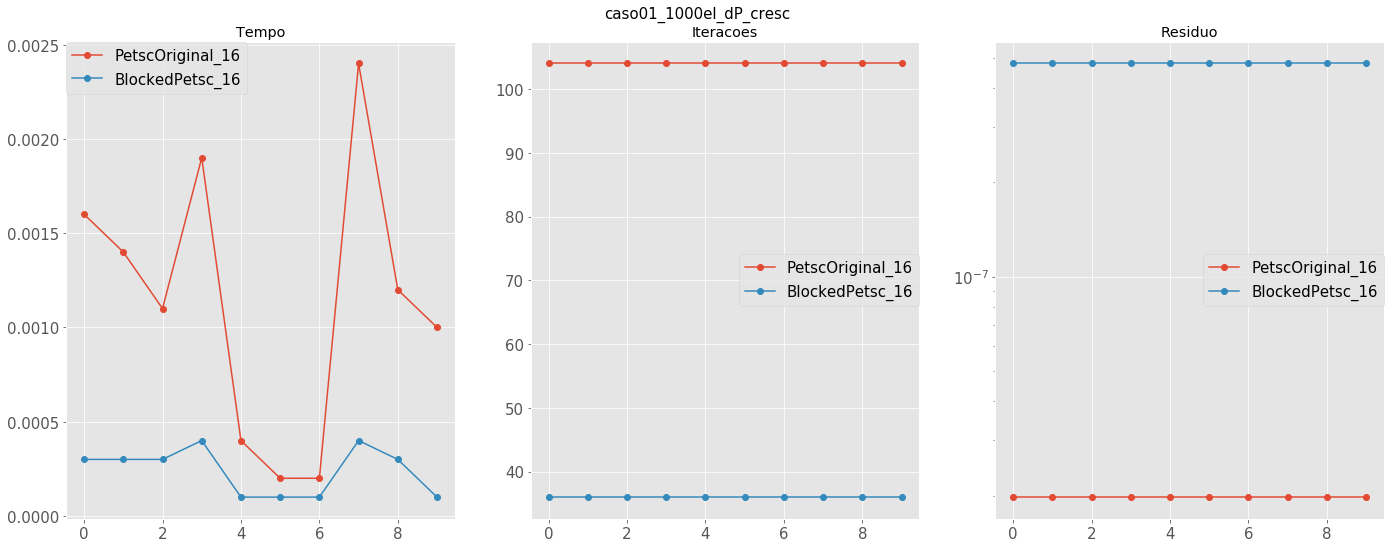

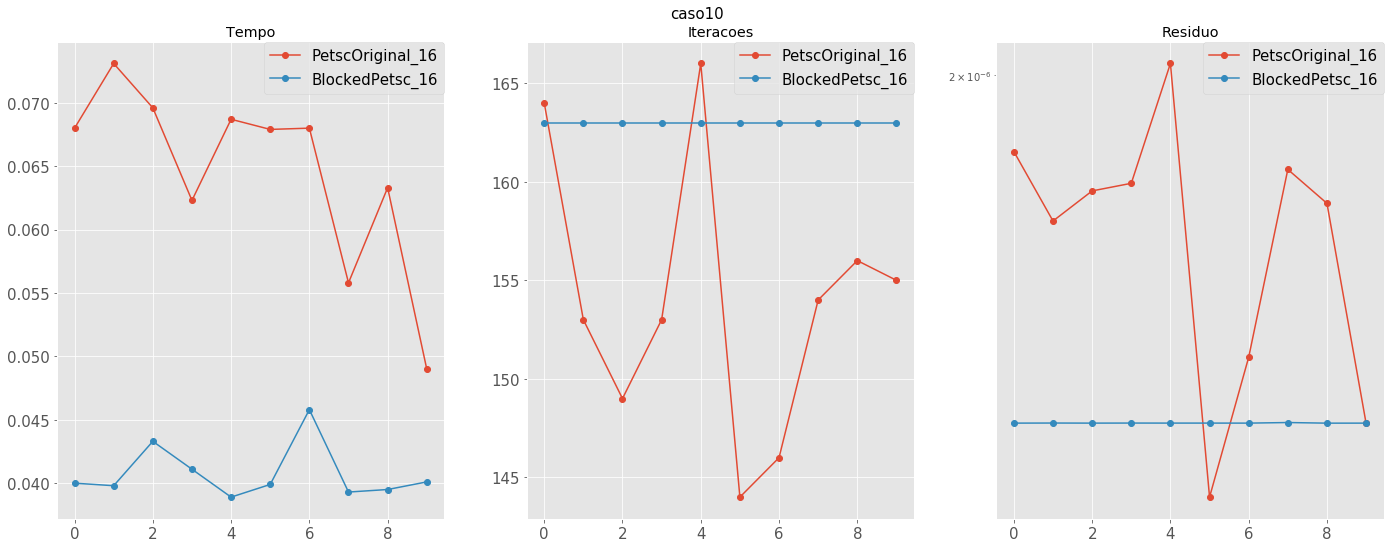

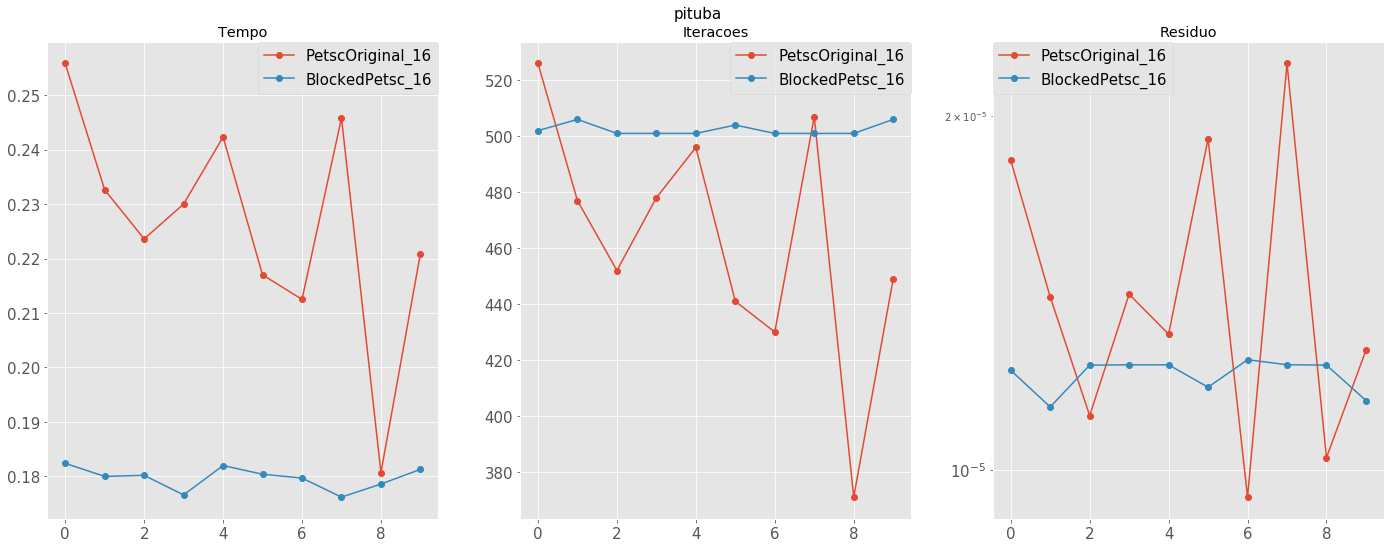

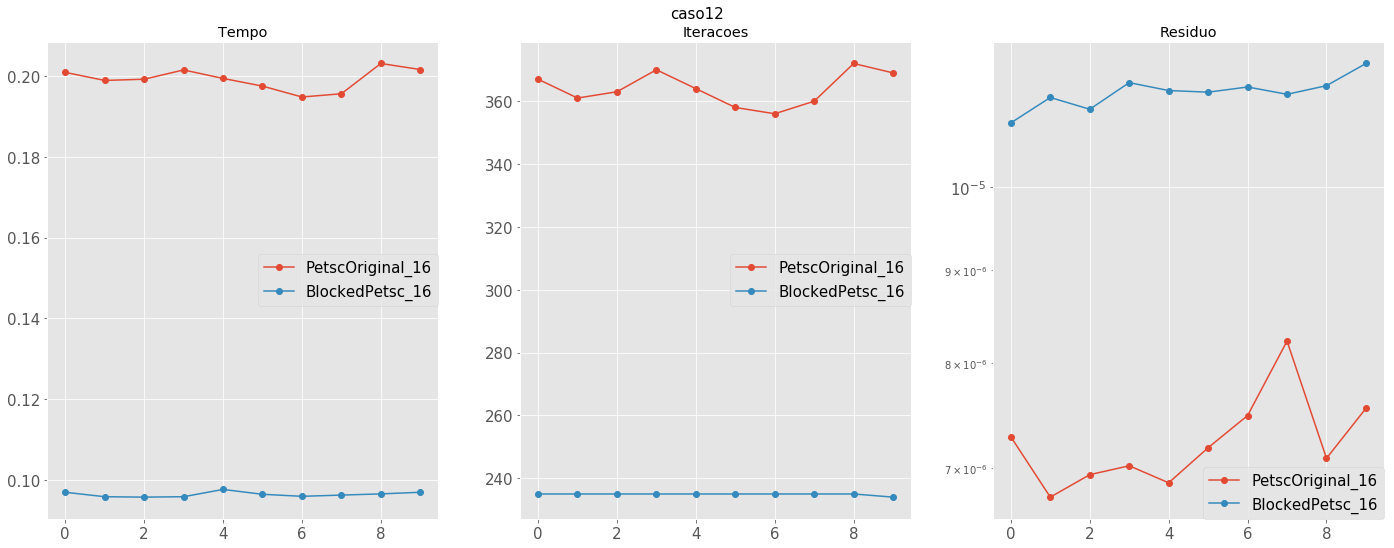

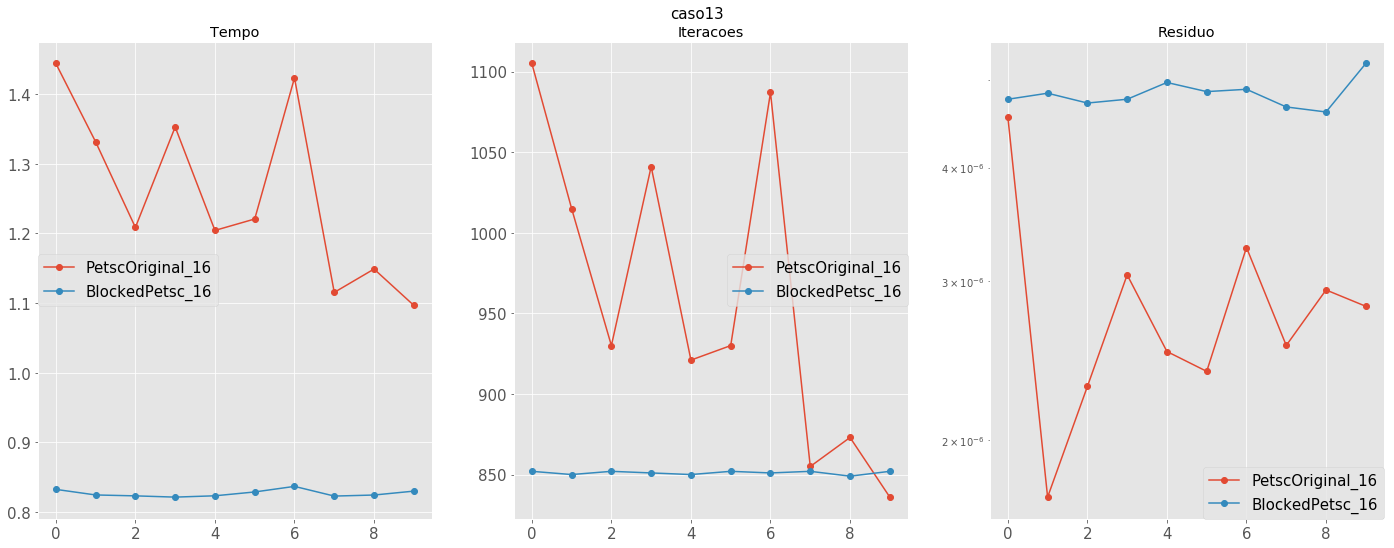

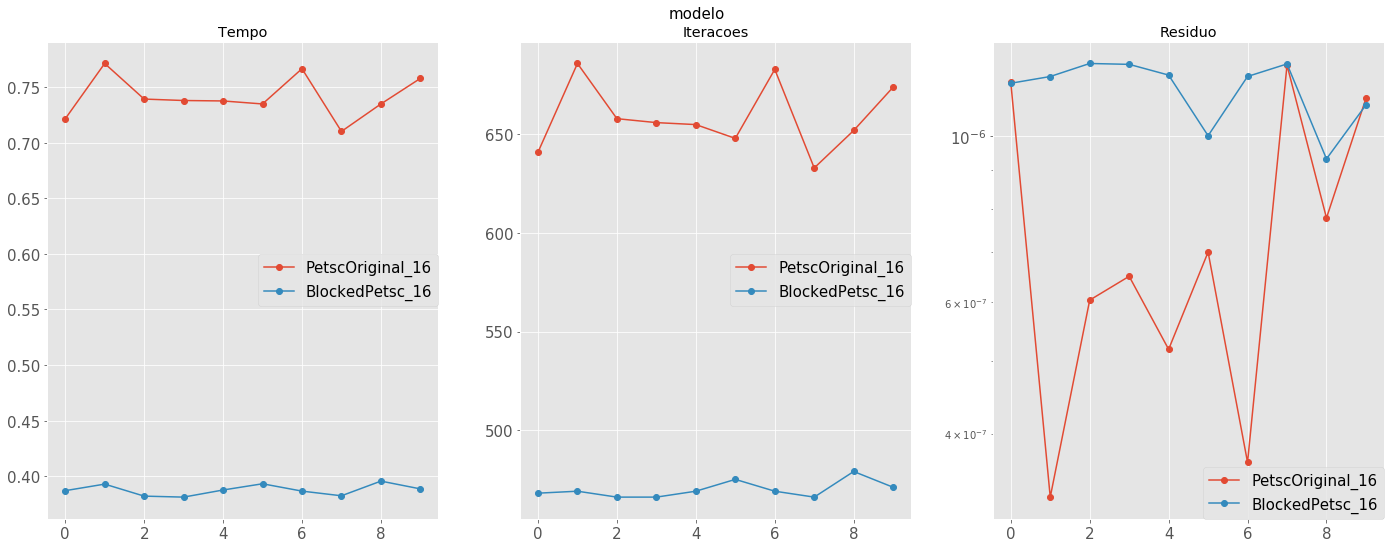

In [139]:
results = pd.DataFrame(columns=columns)
path = "./LogSolver/"
for filename in get_glob("rodada_cluster_[0-9]*.txt", path):
    results = results.append(read_results(path+filename), ignore_index=True)    
results["Nos"] = 1
plot_tempo_iters_residuo(results, procs=[16])

# Resultados para 2 nós - tol 1.0d-6

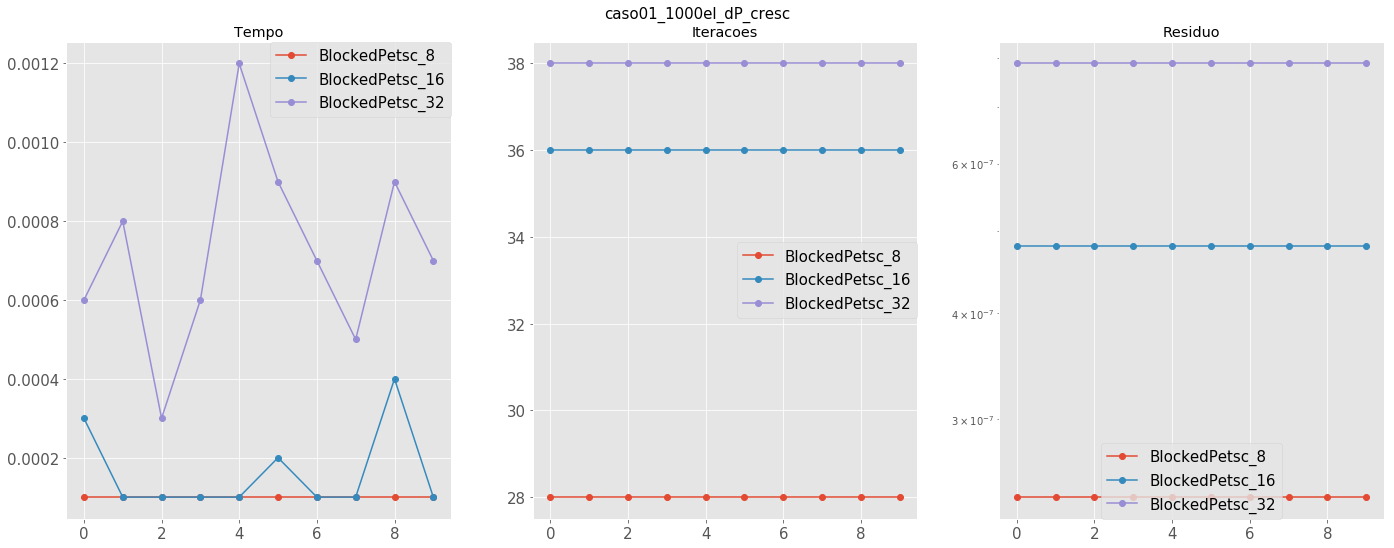

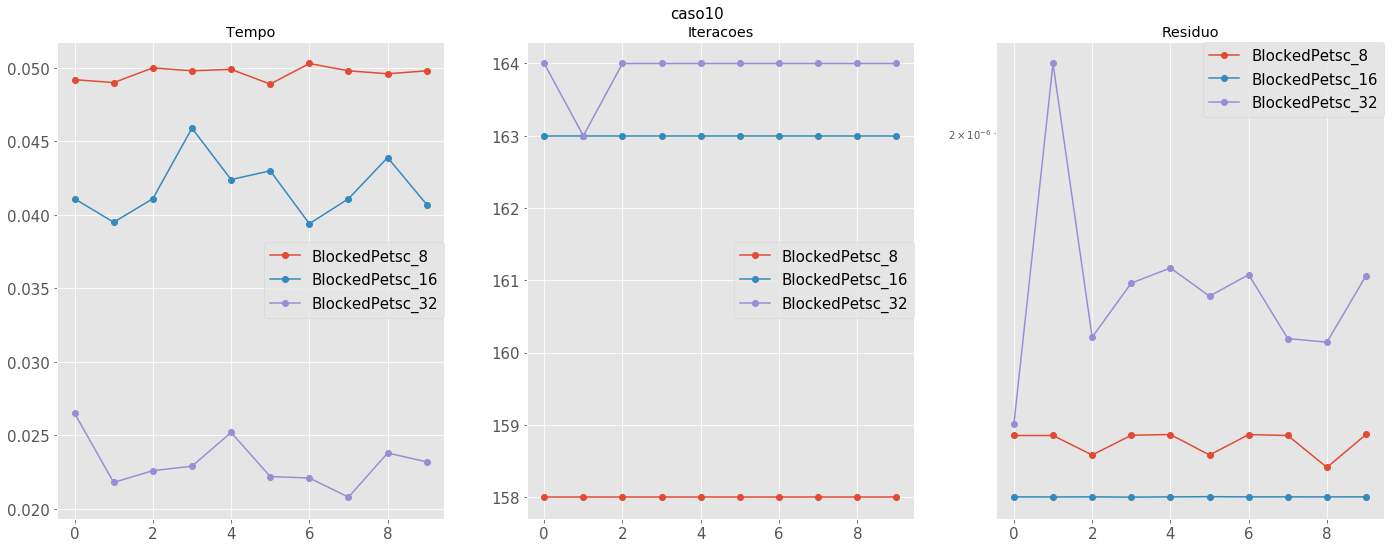

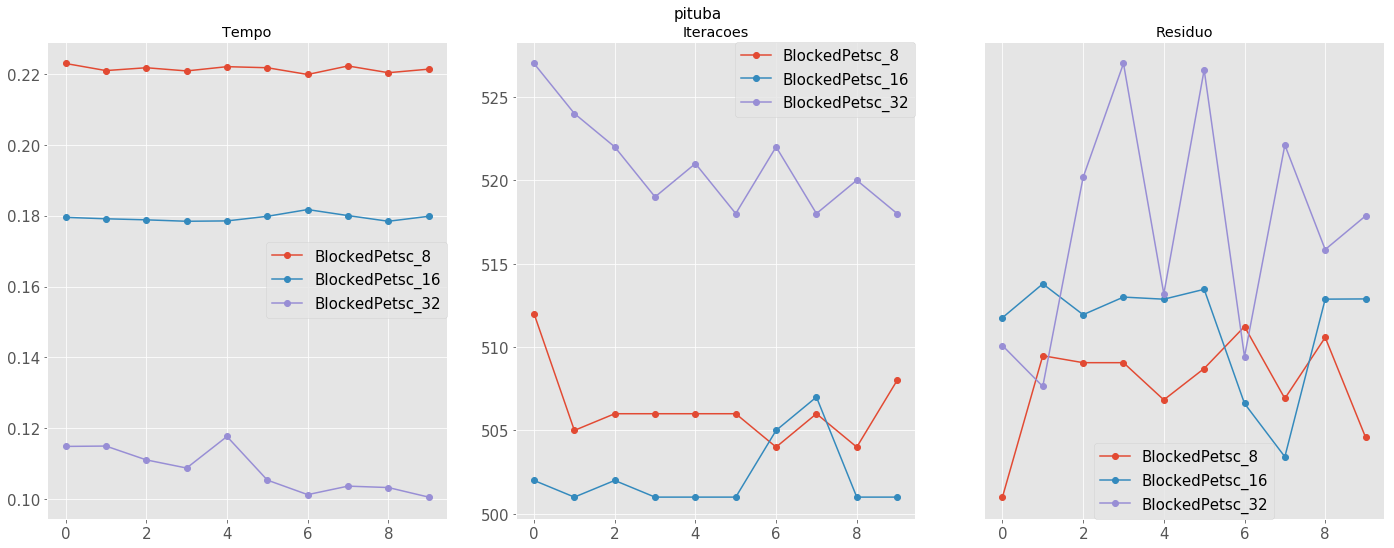

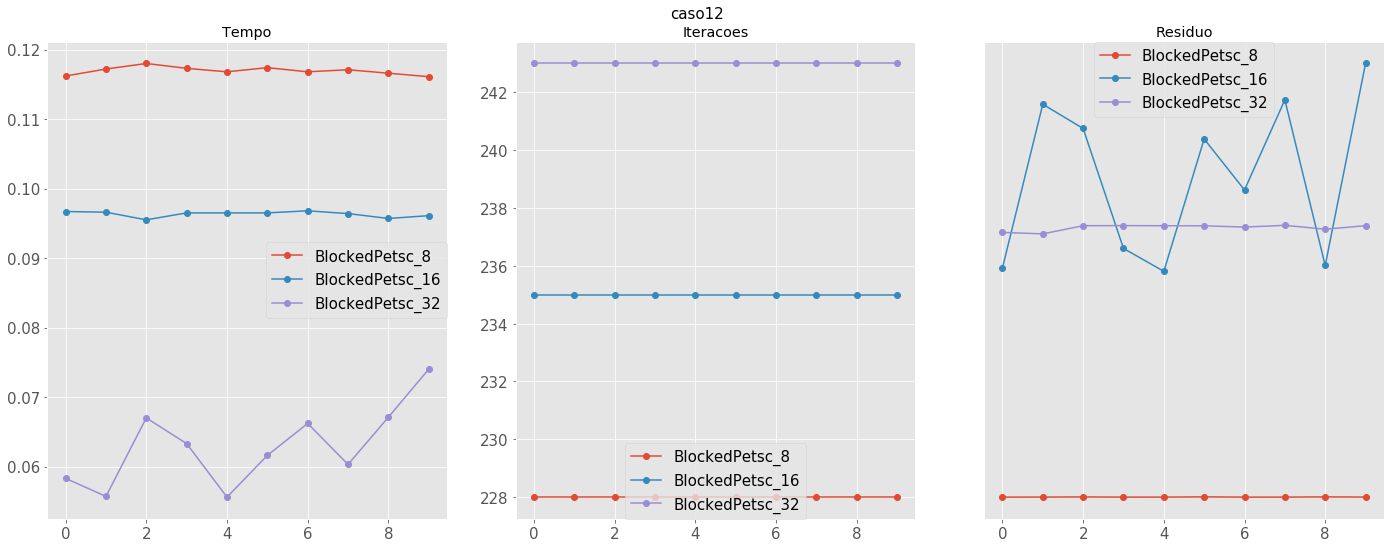

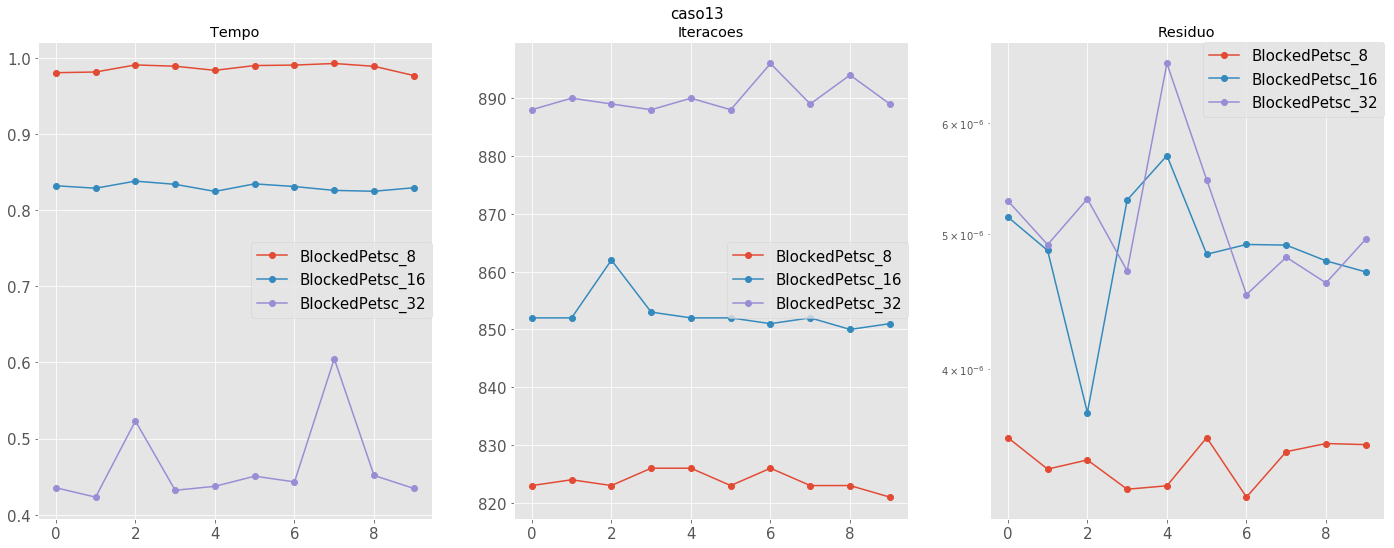

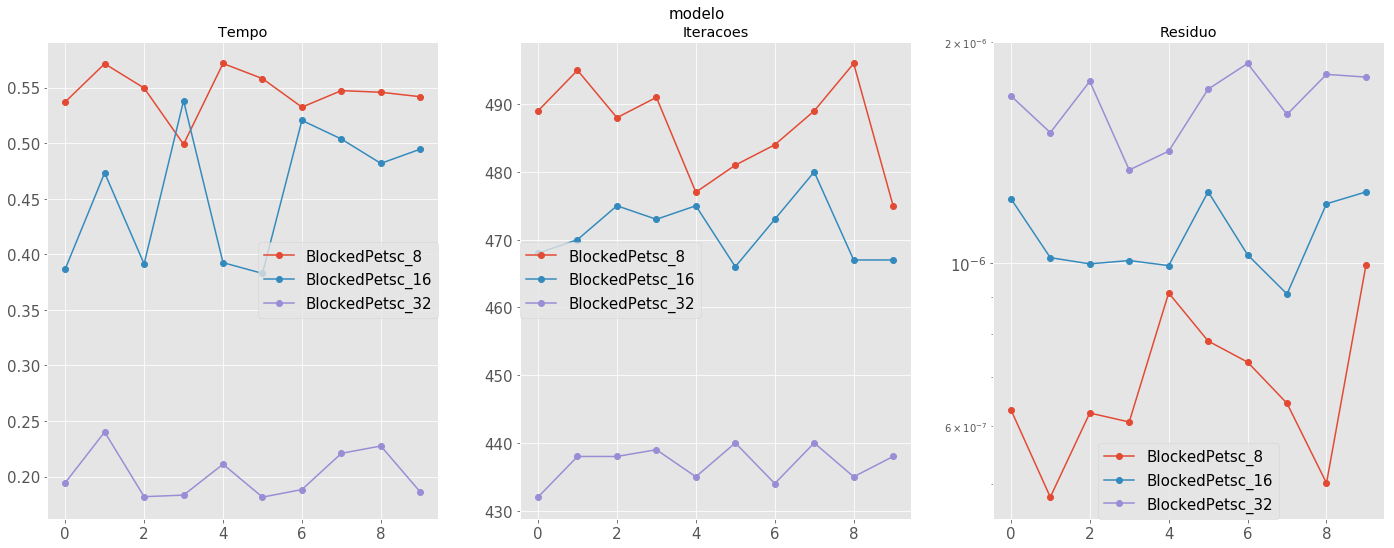

In [140]:
results = pd.DataFrame(columns=columns)

files = glob.glob("./LogSolver/rodada_cluster_2nos_[0-9]*.txt")

for filename in files:
    results = results.append(read_results(filename), ignore_index=True)    
results["Nos"] = 2
plot_tempo_iters_residuo(results, procs = [8, 16, 32], tipos = ["BlockedPetsc"])

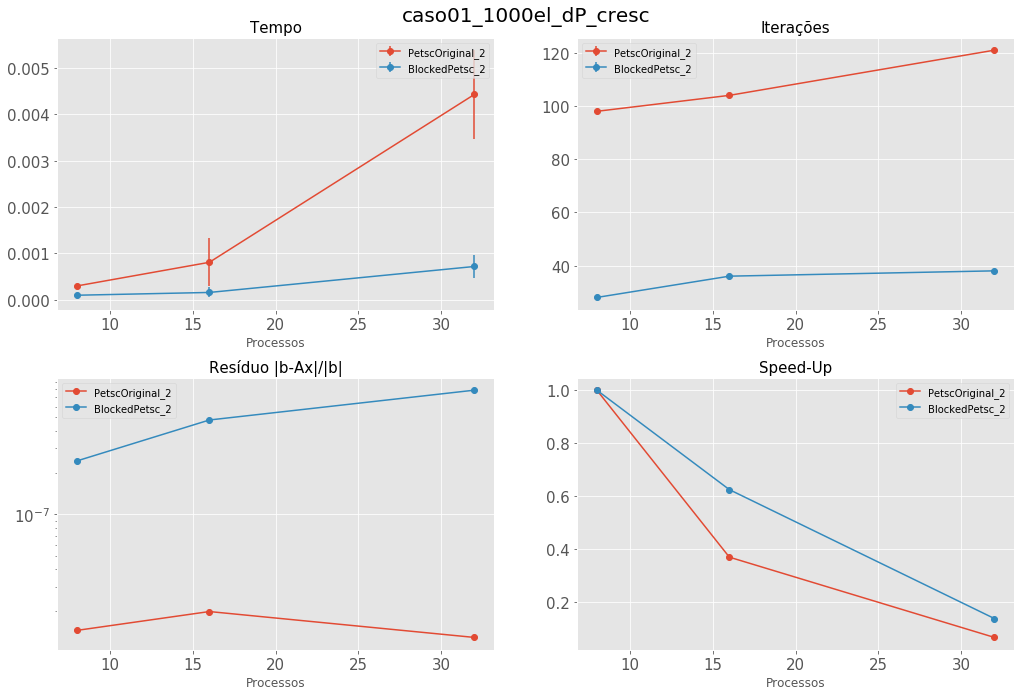

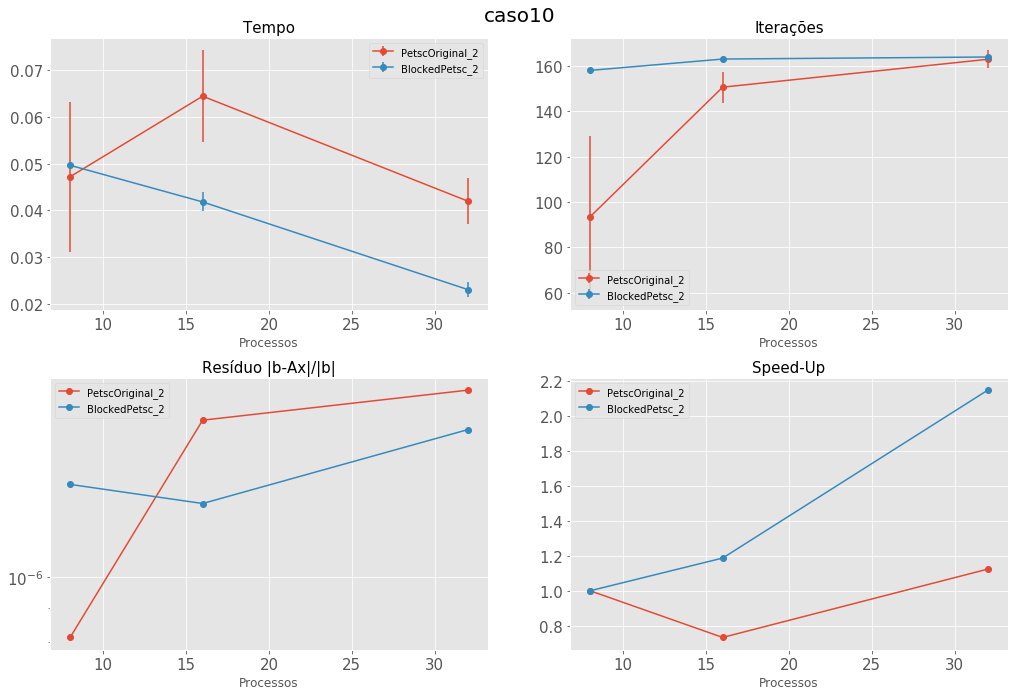

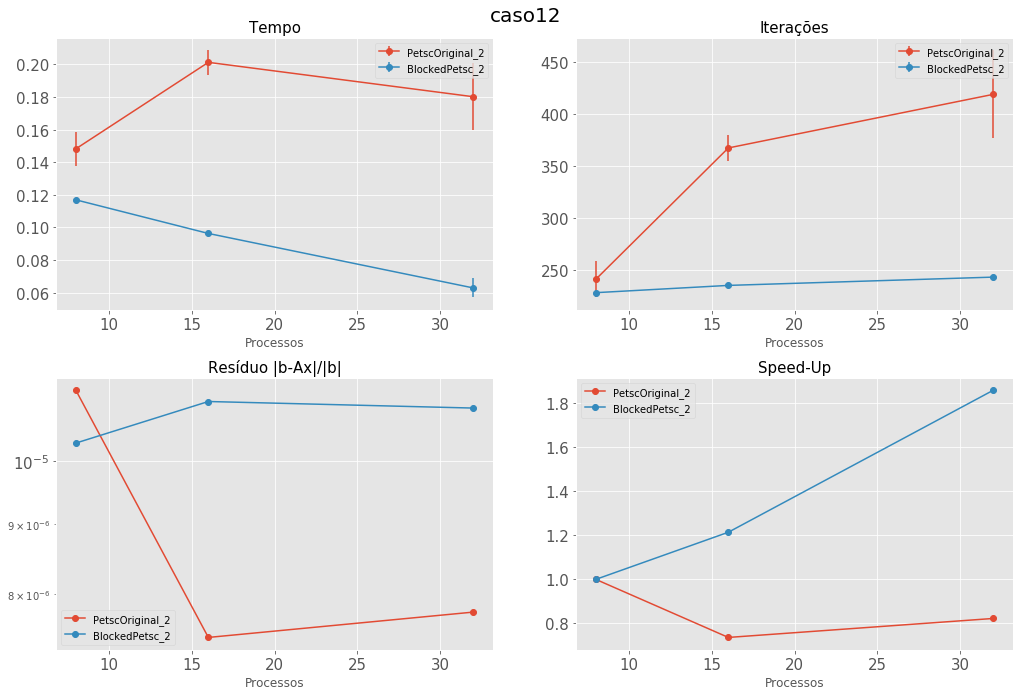

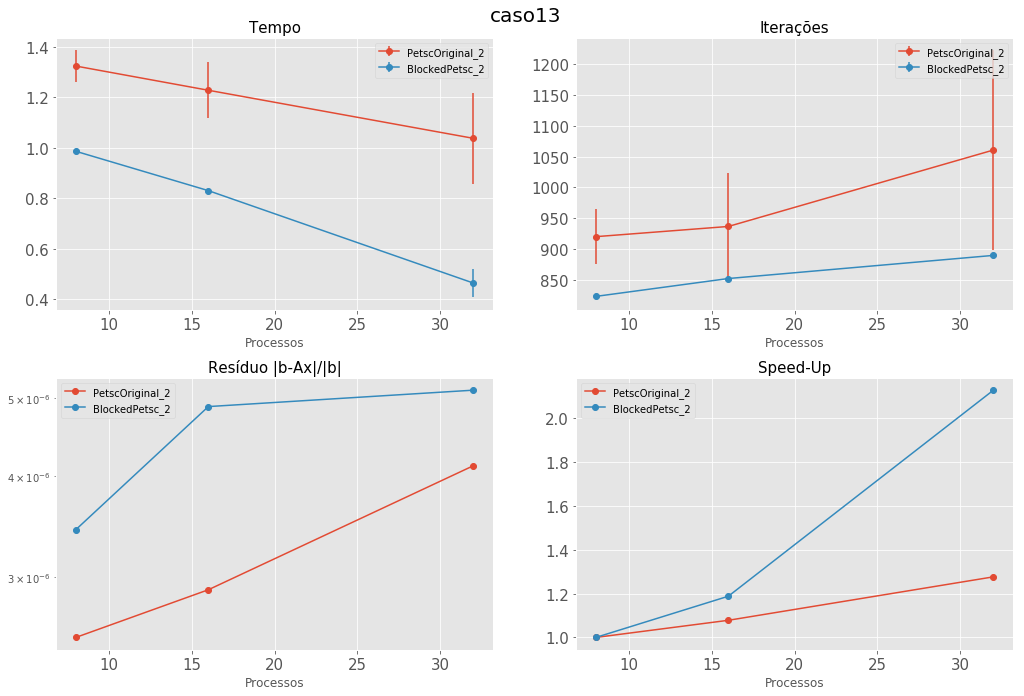

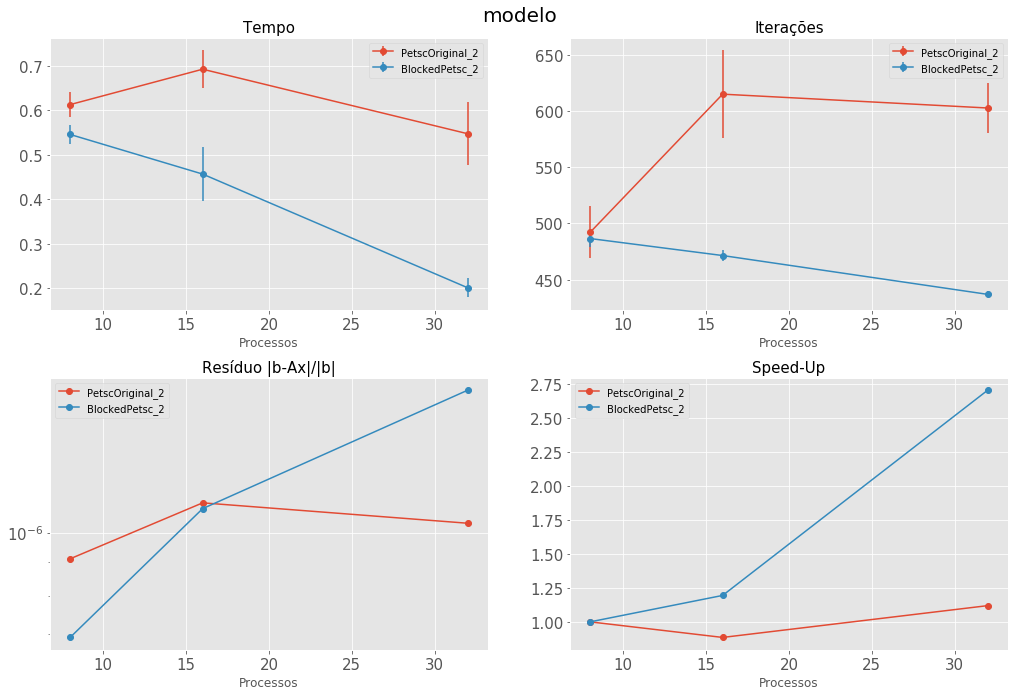

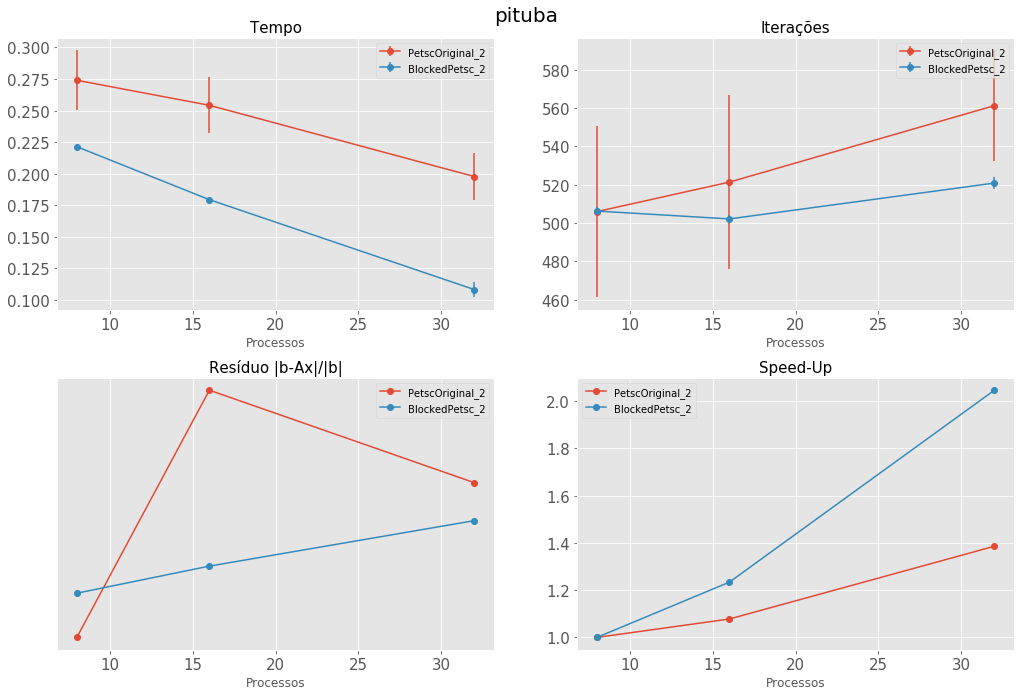

In [141]:
results["Iteracoes"] = results["Iteracoes"].astype(int)

mean_data = get_mean_data(results, ["Caso", "Tipo", "Processos"], ["TempoSolver", "Residuo", "Iteracoes"])

plot_mean_data(mean_data, tipos=["PetscOriginal", "BlockedPetsc"])



In [142]:
mean_data[mean_data.Caso=="pituba"]

Caso           Tipo  Processos  TempoSolver  Iteracoes   Residuo  Nos  \
30  pituba   BlockedPetsc          8      0.22136      506.3  0.000012  2.0   
31  pituba   BlockedPetsc         16      0.17940      502.2  0.000012  2.0   
32  pituba   BlockedPetsc         32      0.10818      520.9  0.000013  2.0   
33  pituba  PetscOriginal          8      0.27398      506.0  0.000011  2.0   
34  pituba  PetscOriginal         16      0.25415      521.4  0.000016  2.0   
35  pituba  PetscOriginal         32      0.19770      561.3  0.000014  2.0   

    TempoSolverStd    ResiduoStd  IteracoesStd  
30        0.000931  3.871709e-07      2.311805  
31        0.001013  4.455722e-07      2.097618  
32        0.006215  1.000612e-06      2.960856  
33        0.023848  1.821406e-06     44.763576  
34        0.022237  4.702013e-06     45.566069  
35        0.018891  3.795761e-06     28.929224

# Resultados para 4 nós - tol 1.0d-6

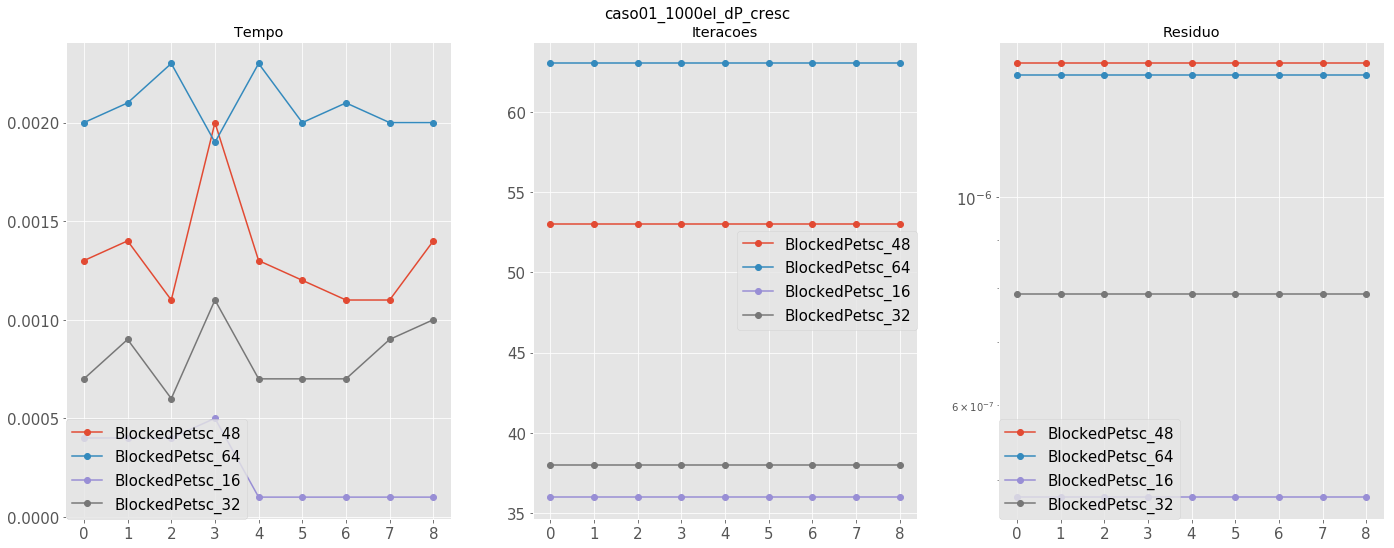

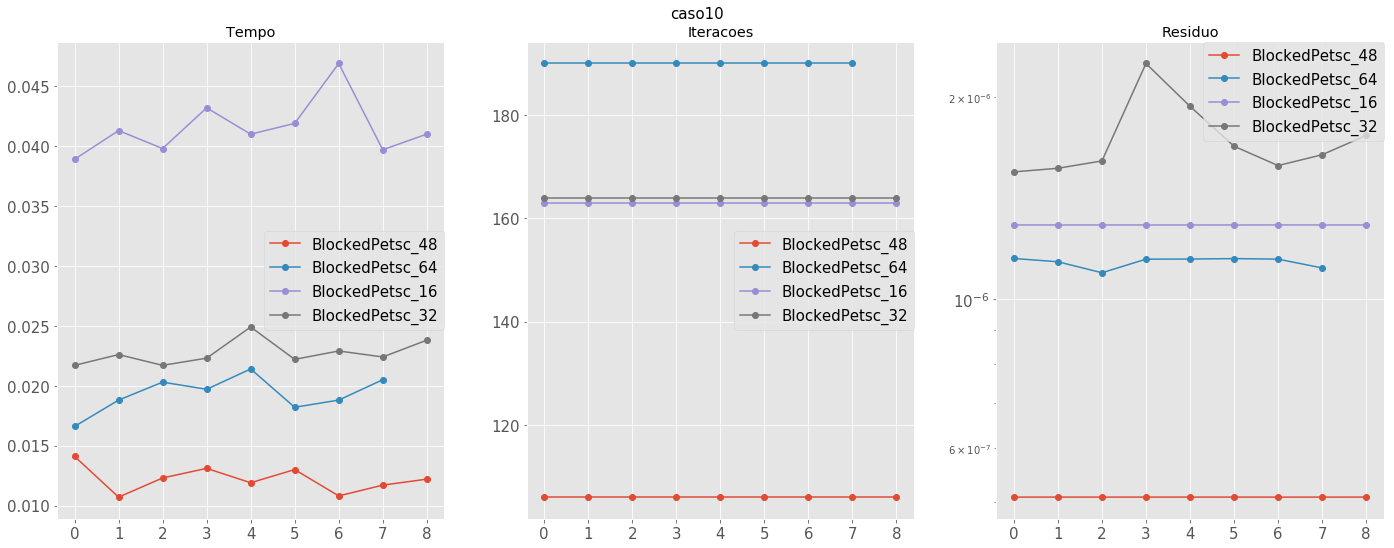

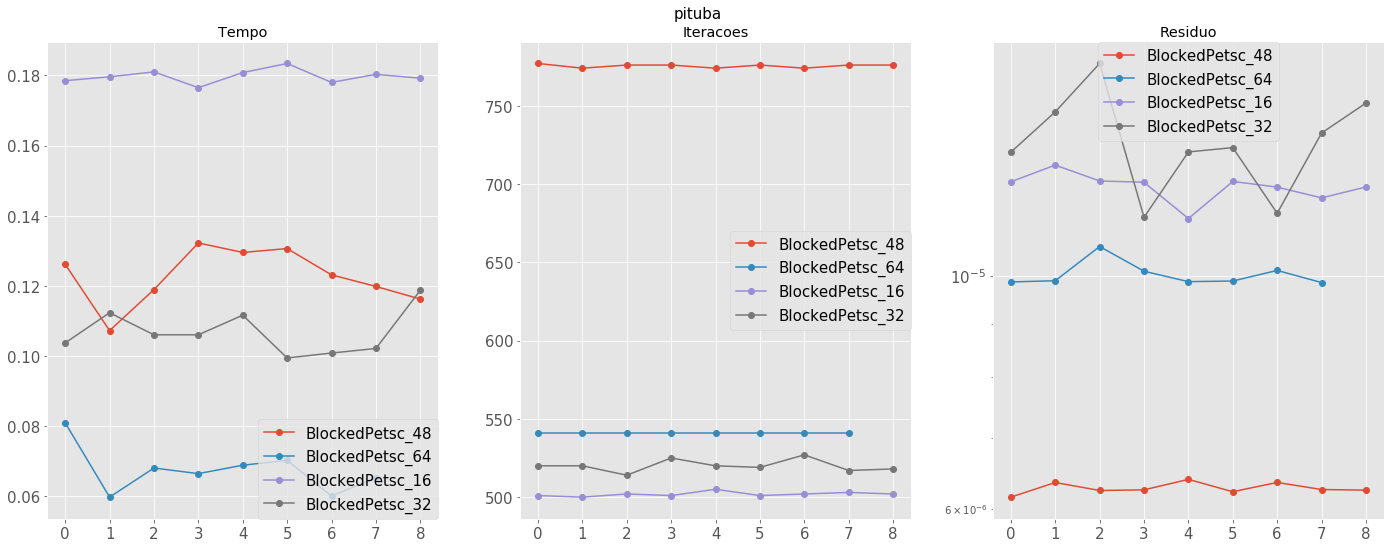

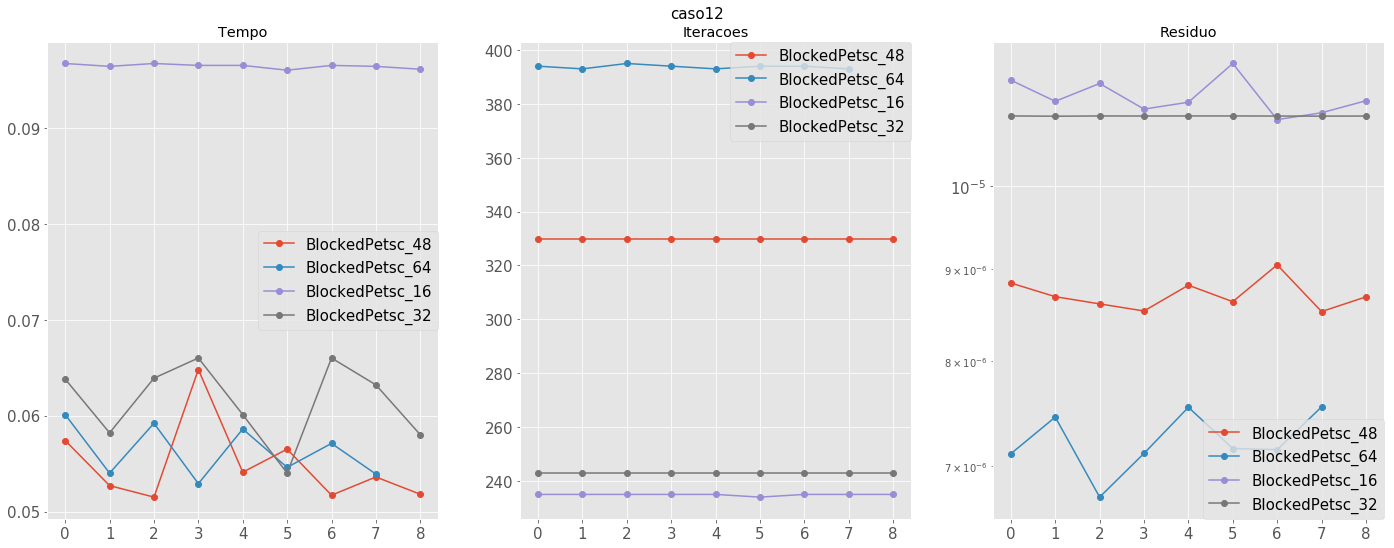

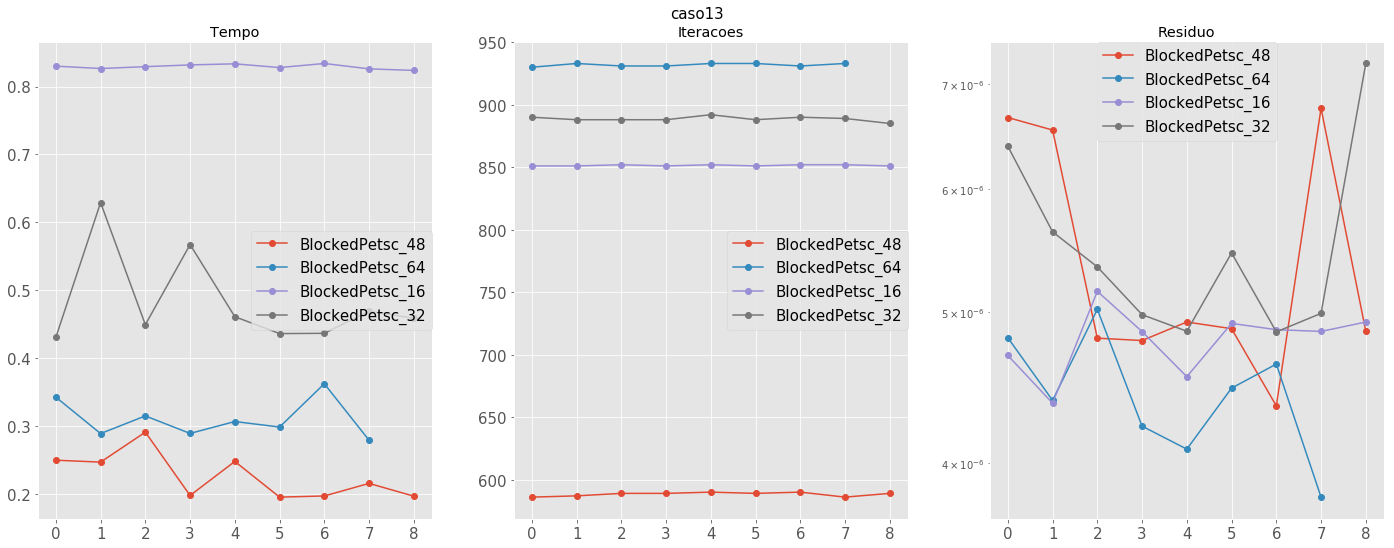

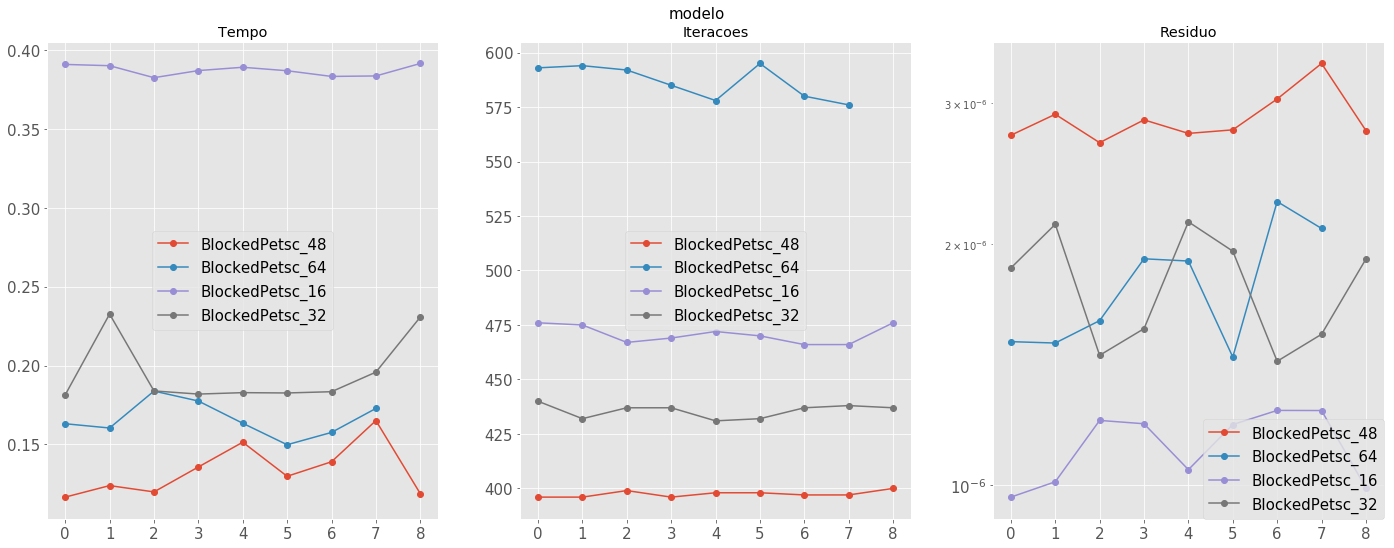

In [143]:
results = pd.DataFrame(columns=columns)
files = glob.glob("LogSolver/rodada_cluster_4nos*.txt")

for filename in files:
    results = results.append(read_results(filename), ignore_index=True)    
results["Nos"] = 4
plot_tempo_iters_residuo(results, tipos = ["BlockedPetsc"])

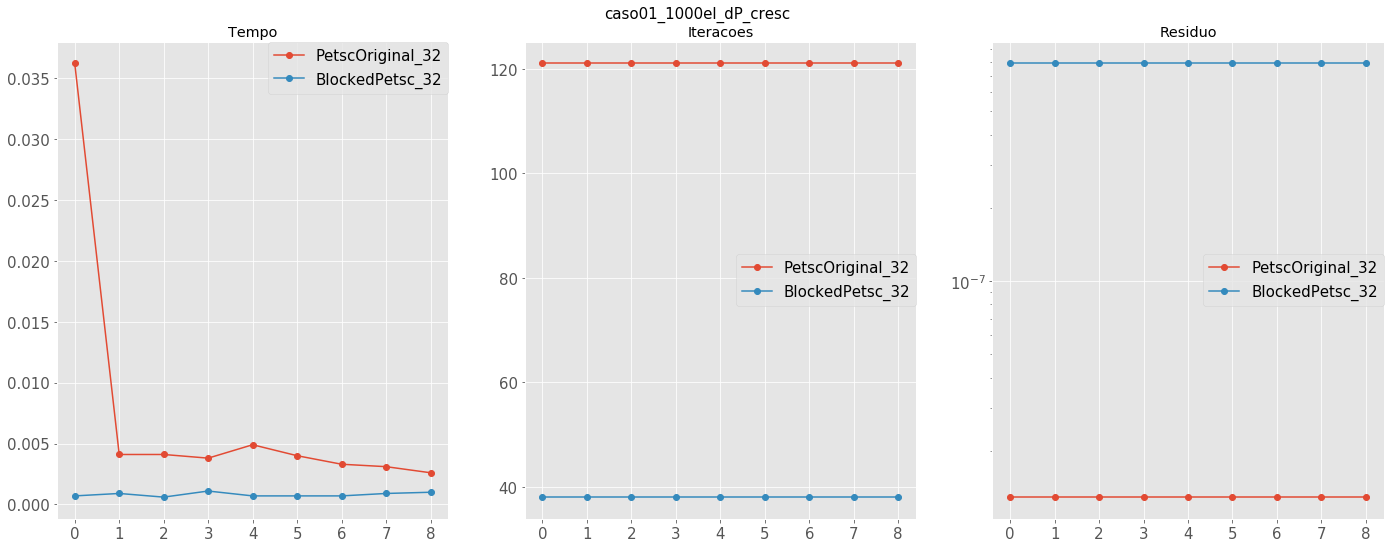

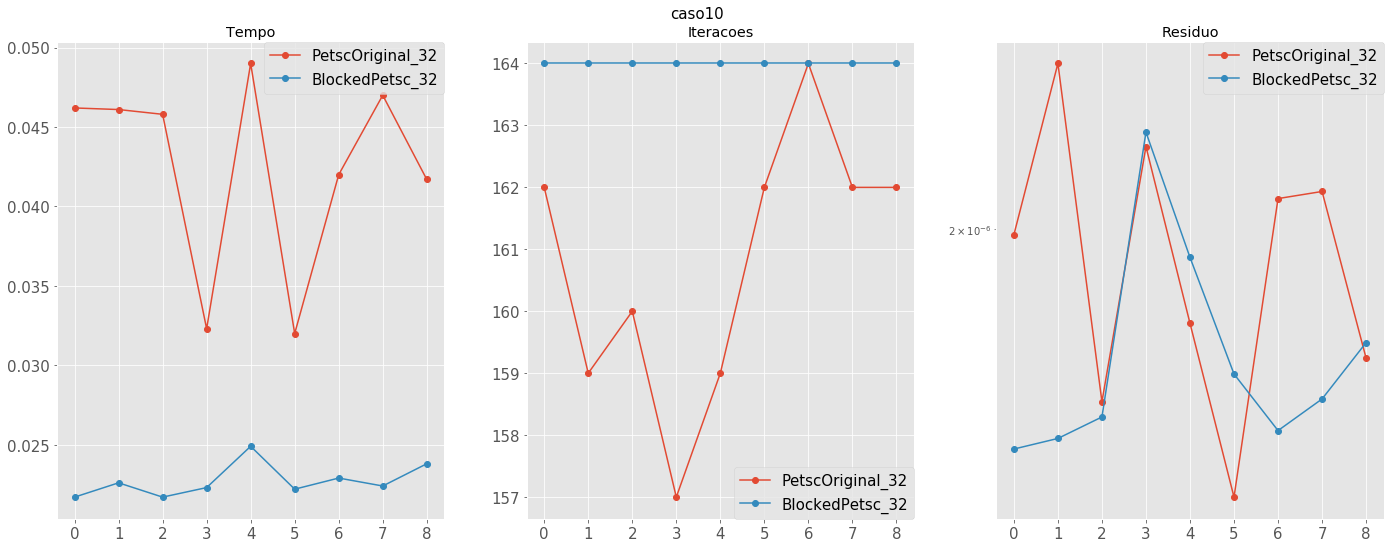

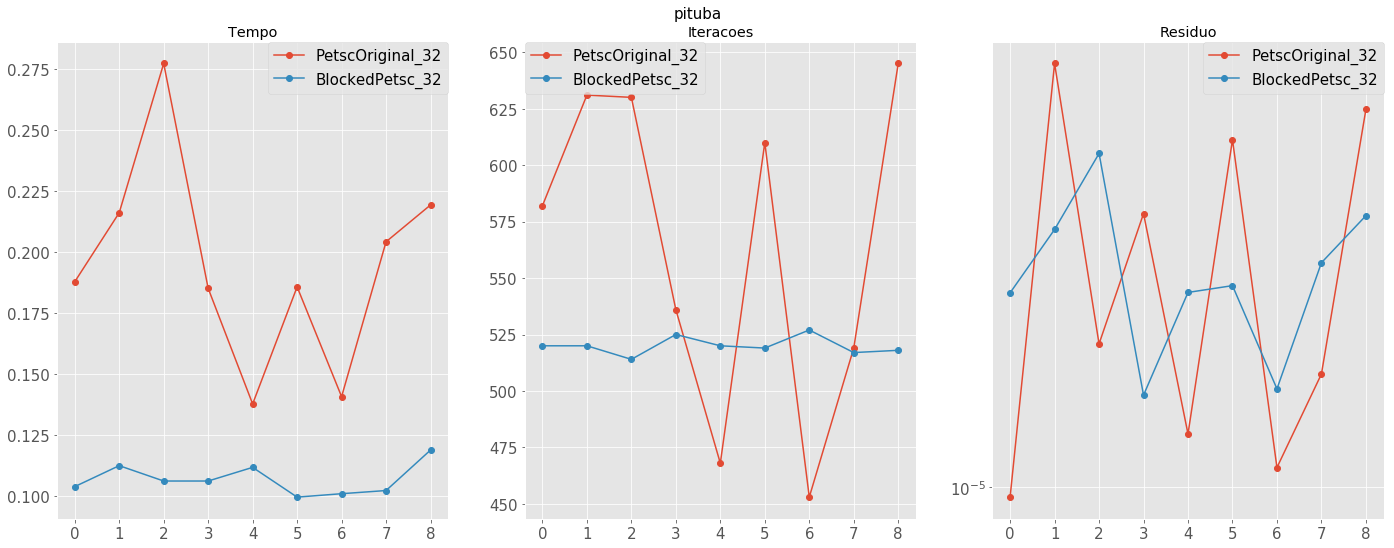

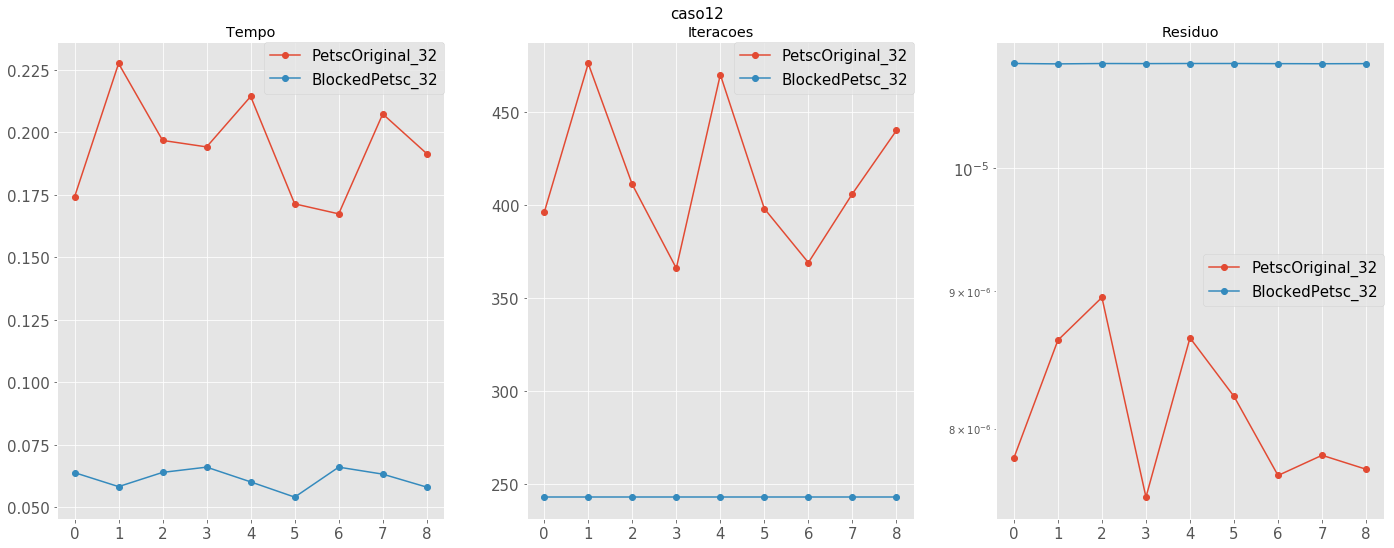

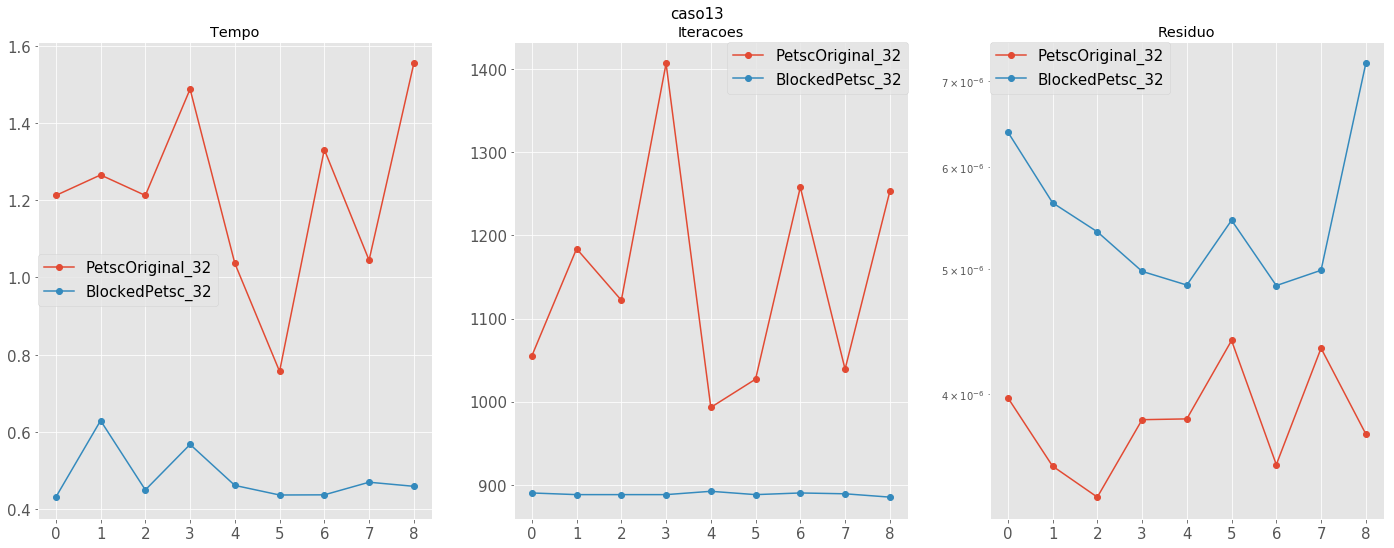

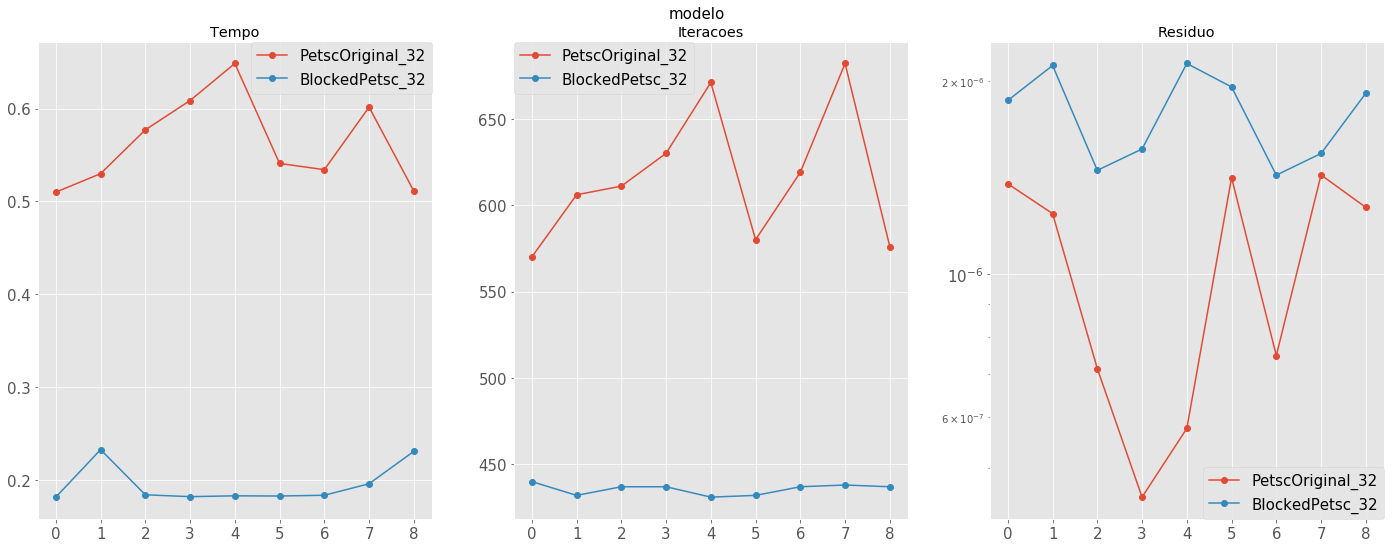

In [144]:
plot_tempo_iters_residuo(results, procs=[32])

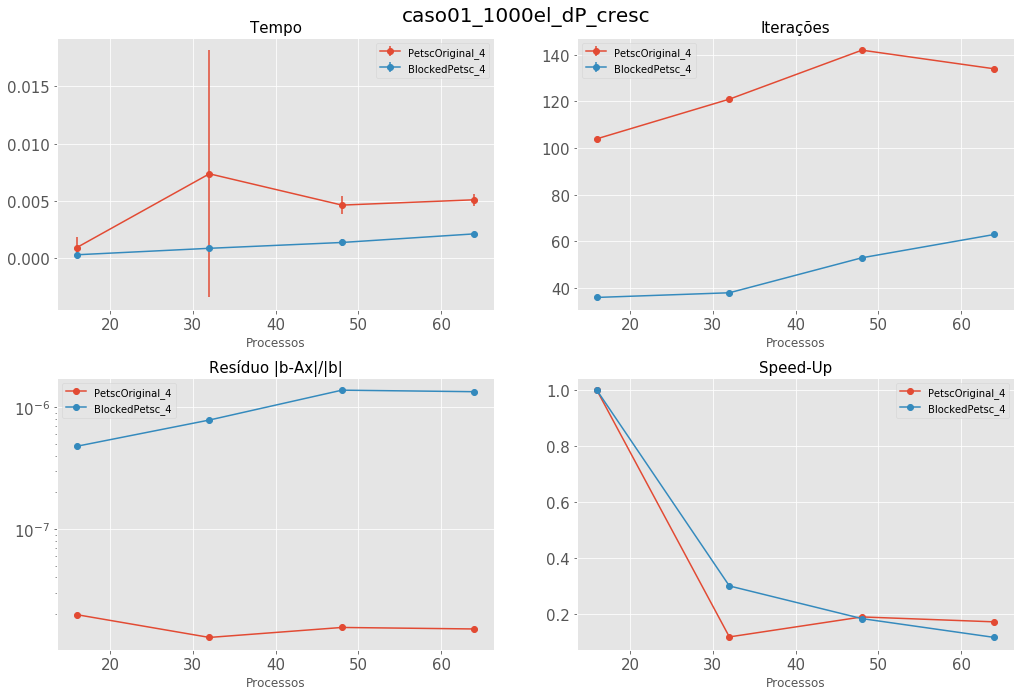

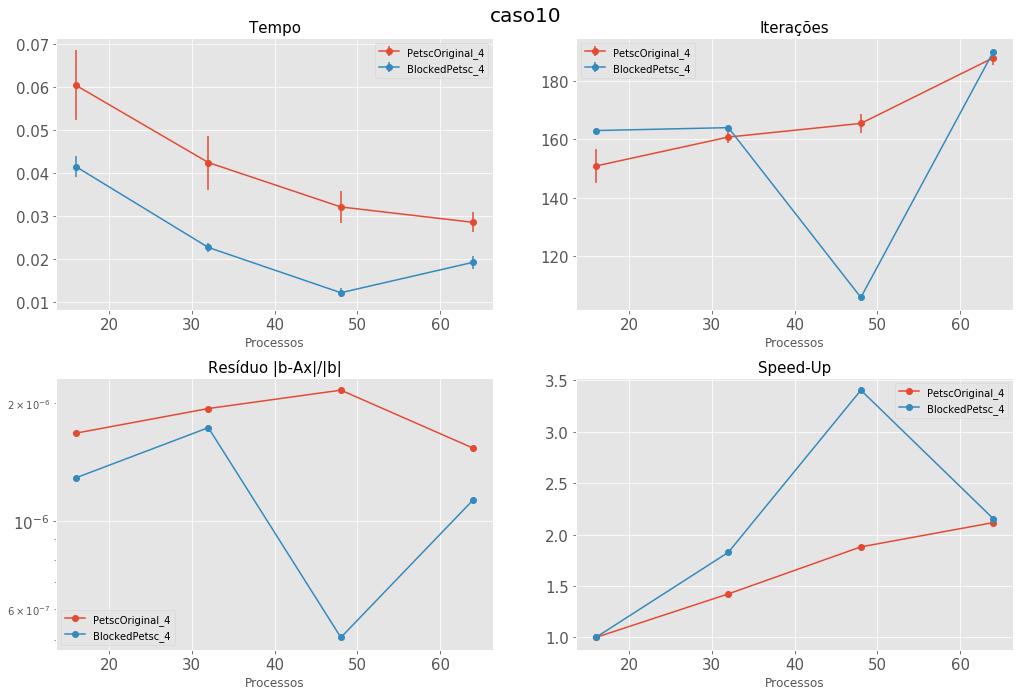

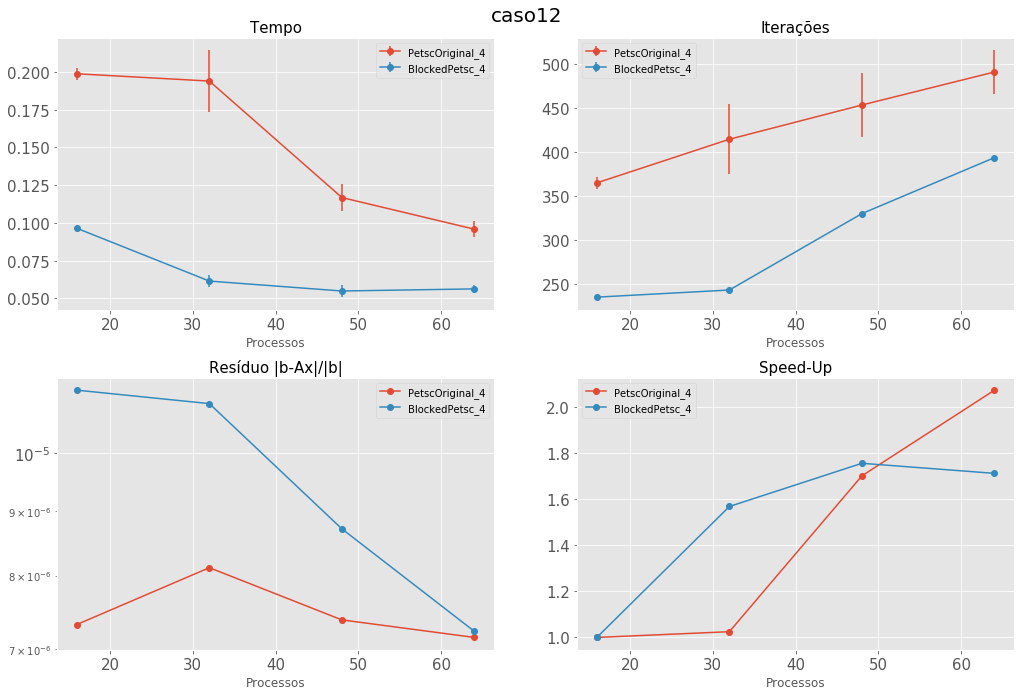

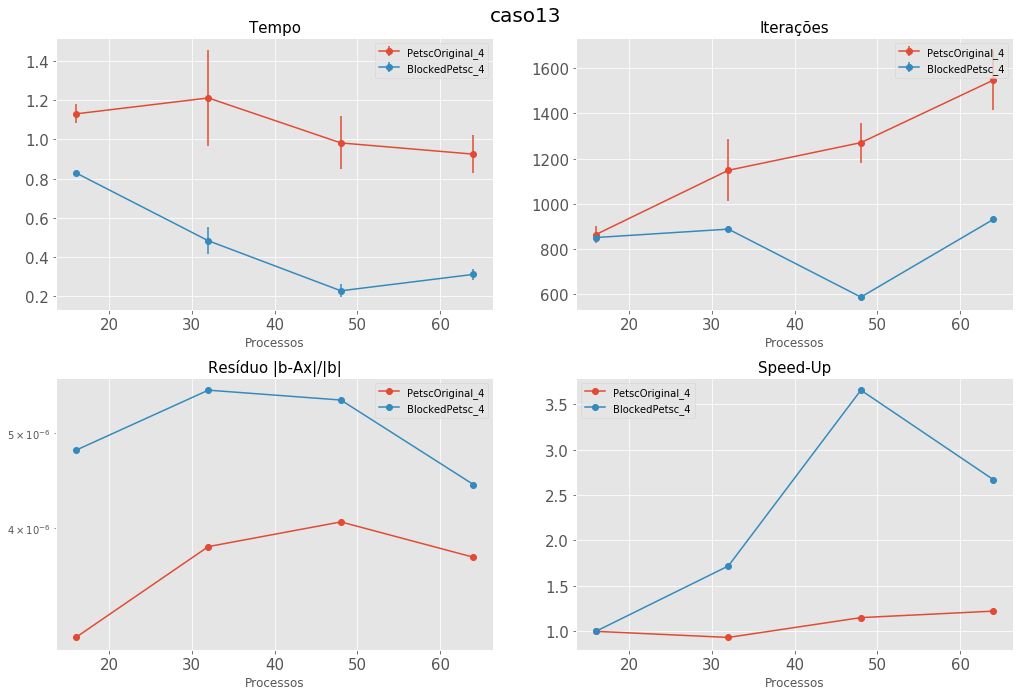

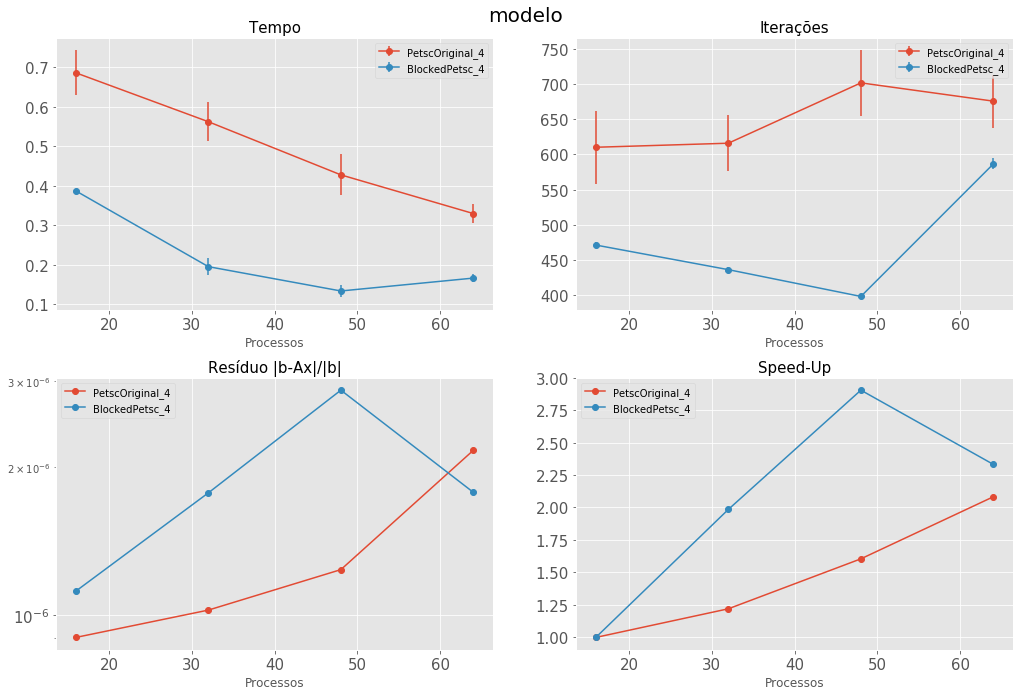

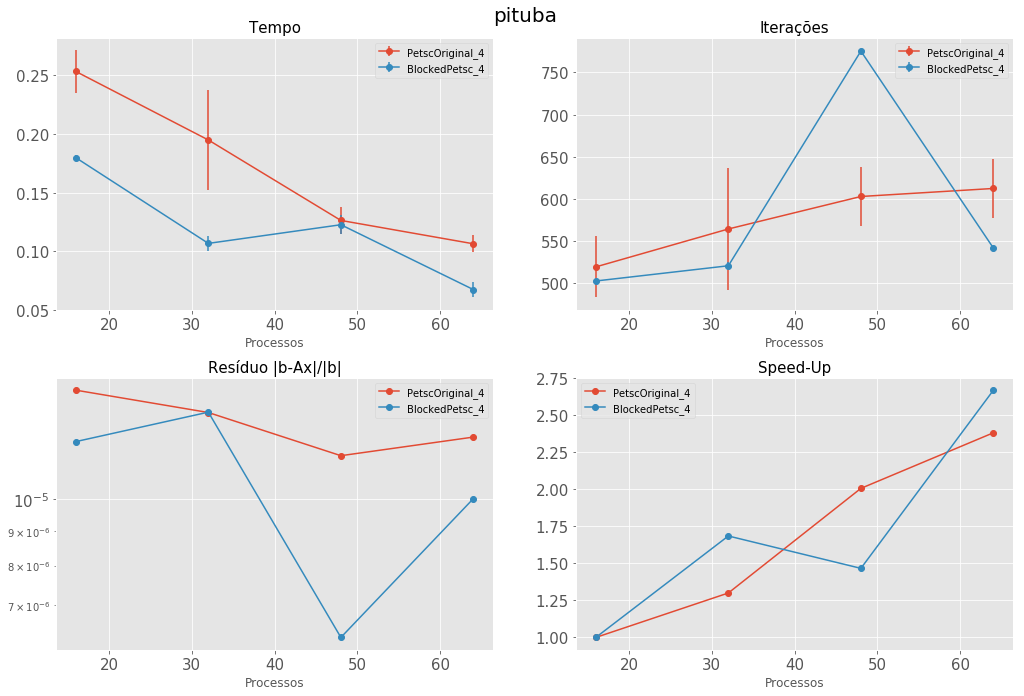

In [145]:
results["Iteracoes"] = results["Iteracoes"].astype(int)
mean_data = get_mean_data(results, ["Caso", "Tipo", "Processos"], ["TempoSolver", "Residuo", "Iteracoes"])
plot_mean_data(mean_data, tipos=["PetscOriginal", "BlockedPetsc"])

In [146]:
results2nos = pd.DataFrame(columns=columns)
files = glob.glob("LogSolver/rodada_cluster_2nos_[0-9]*.txt")

for filename in files:
    results2nos = results2nos.append(read_results(filename), ignore_index=True)    
results2nos["Nos"] = 2

results4nos = pd.DataFrame(columns=columns)
files = glob.glob("LogSolver/rodada_cluster_4nos*.txt")
for filename in files:
    results4nos = results4nos.append(read_results(filename), ignore_index=True)    
results4nos["Nos"] = 4


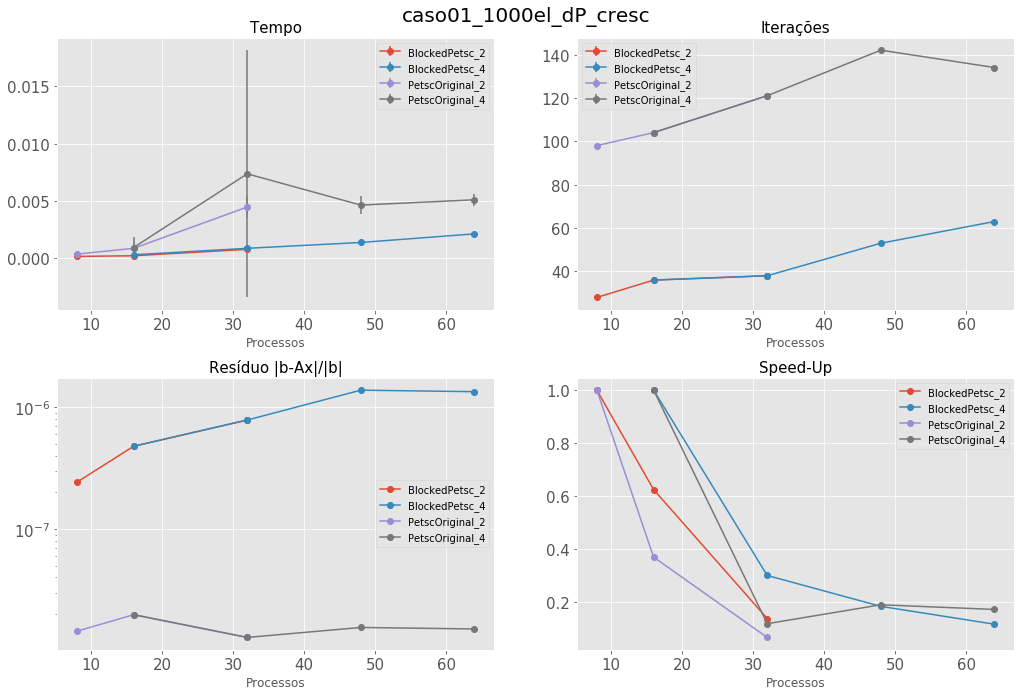

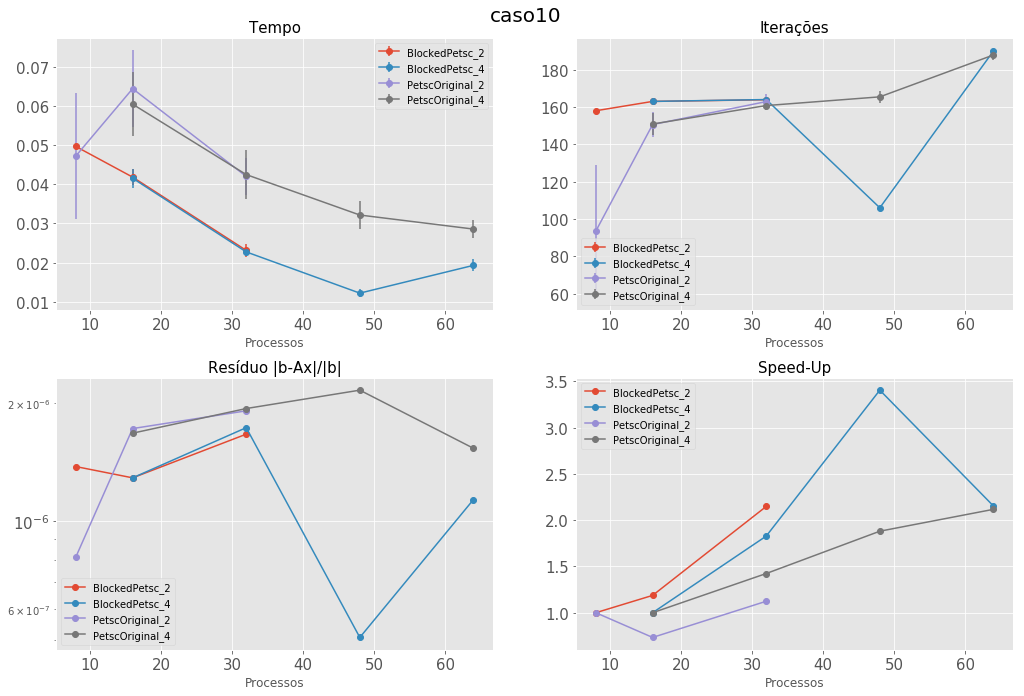

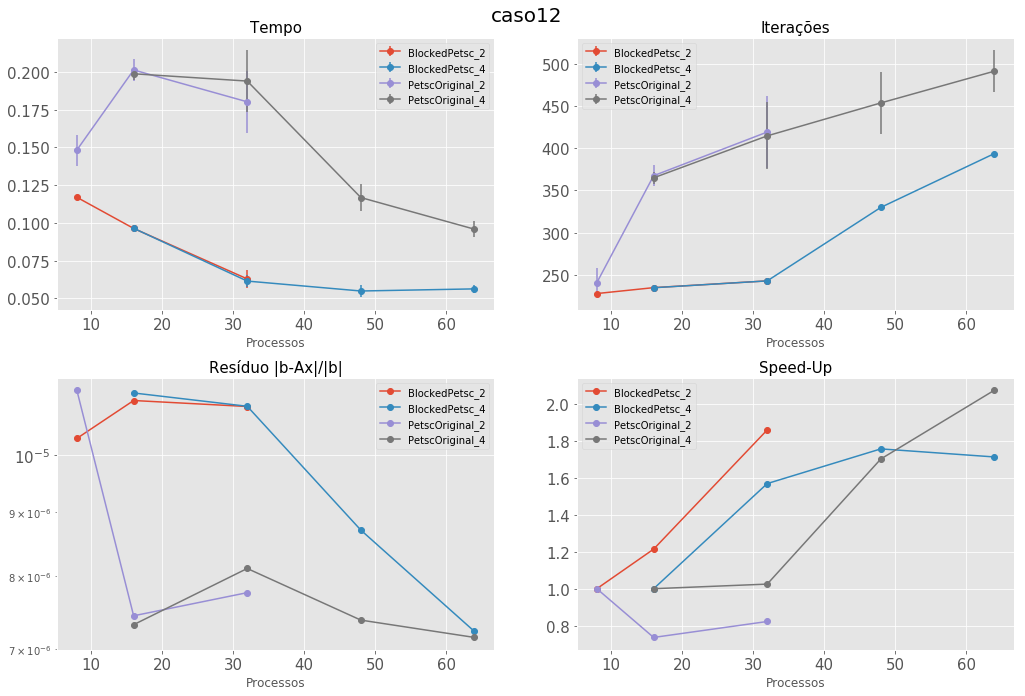

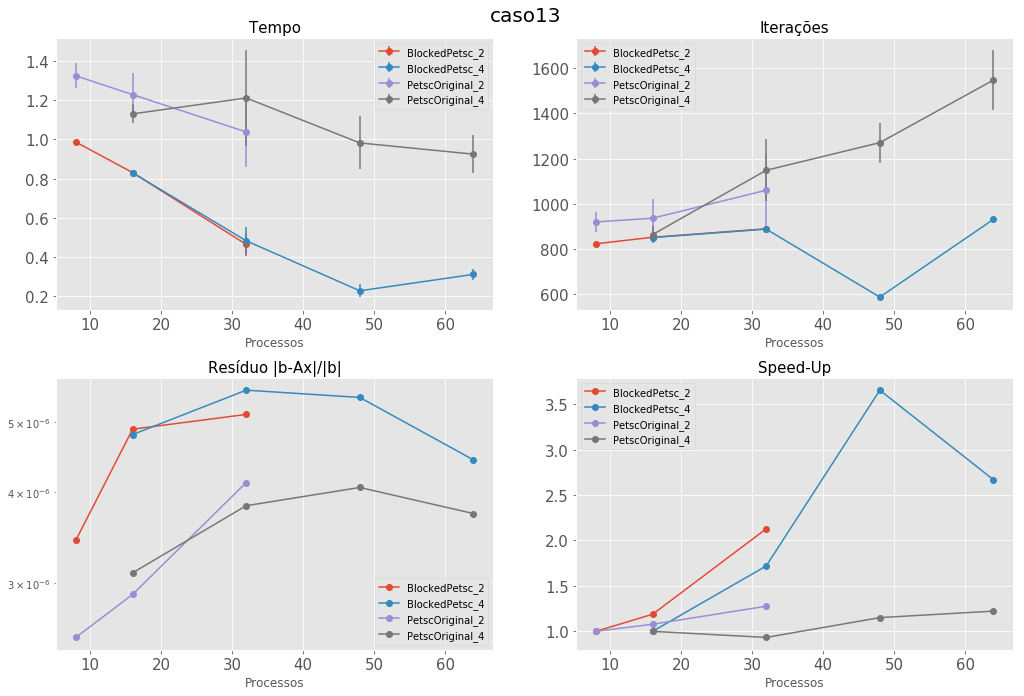

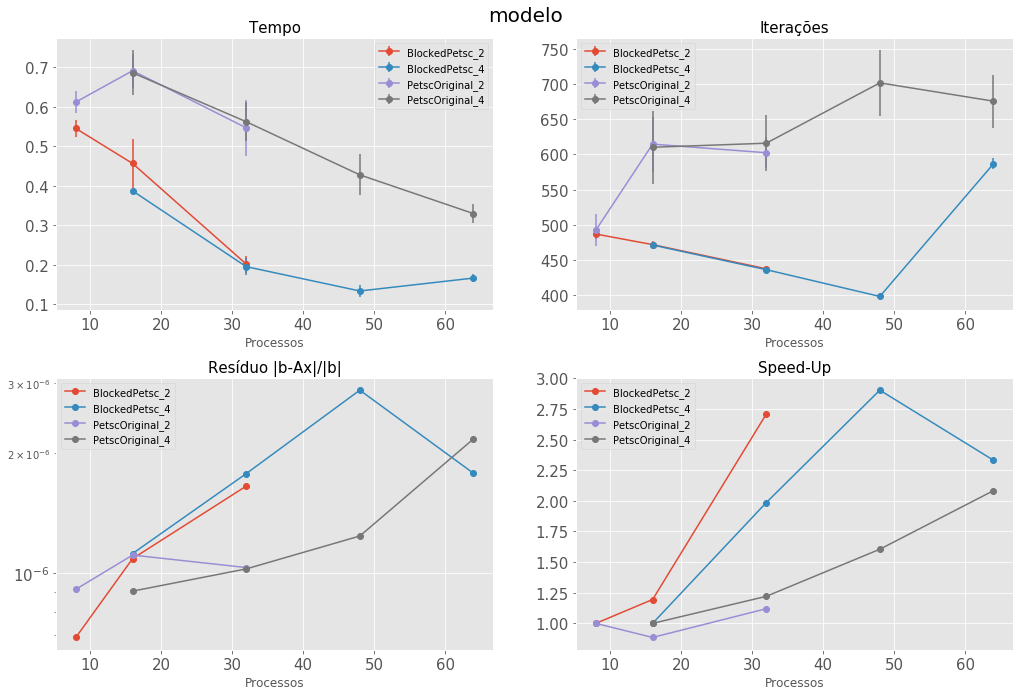

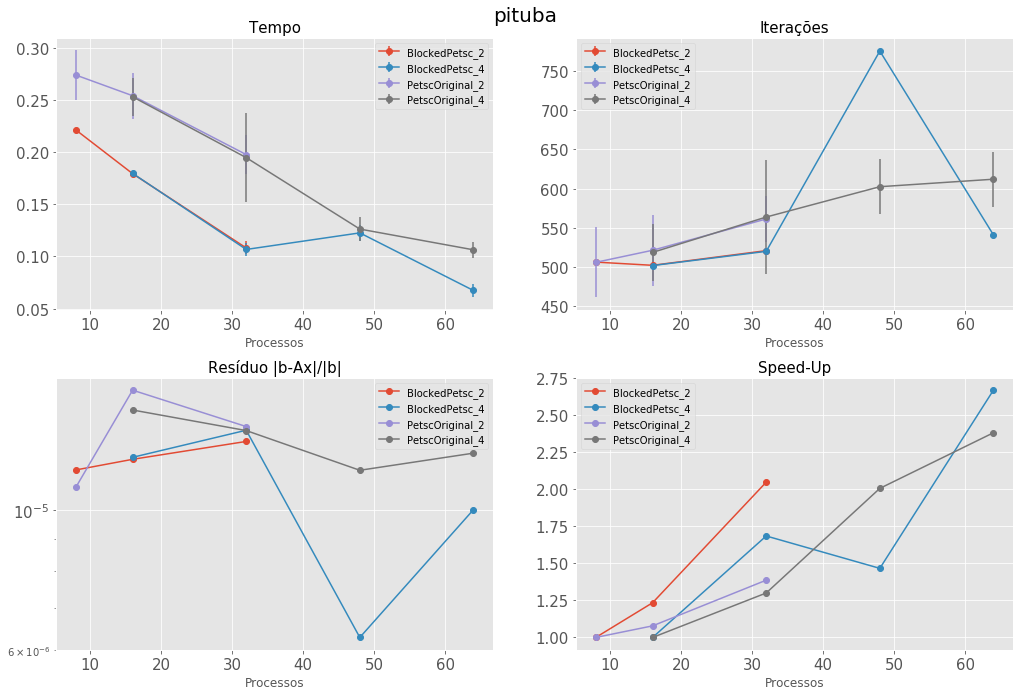

In [147]:
results = results2nos.append(results4nos, ignore_index=True)
results["Iteracoes"] = results["Iteracoes"].astype(int)
mean_data = get_mean_data(results, ["Caso", "Tipo", "Processos", "Nos"], ["TempoSolver", "Residuo", "Iteracoes"])
plot_mean_data(mean_data)

# Resultados para 2 nós - tol 1.0d-10

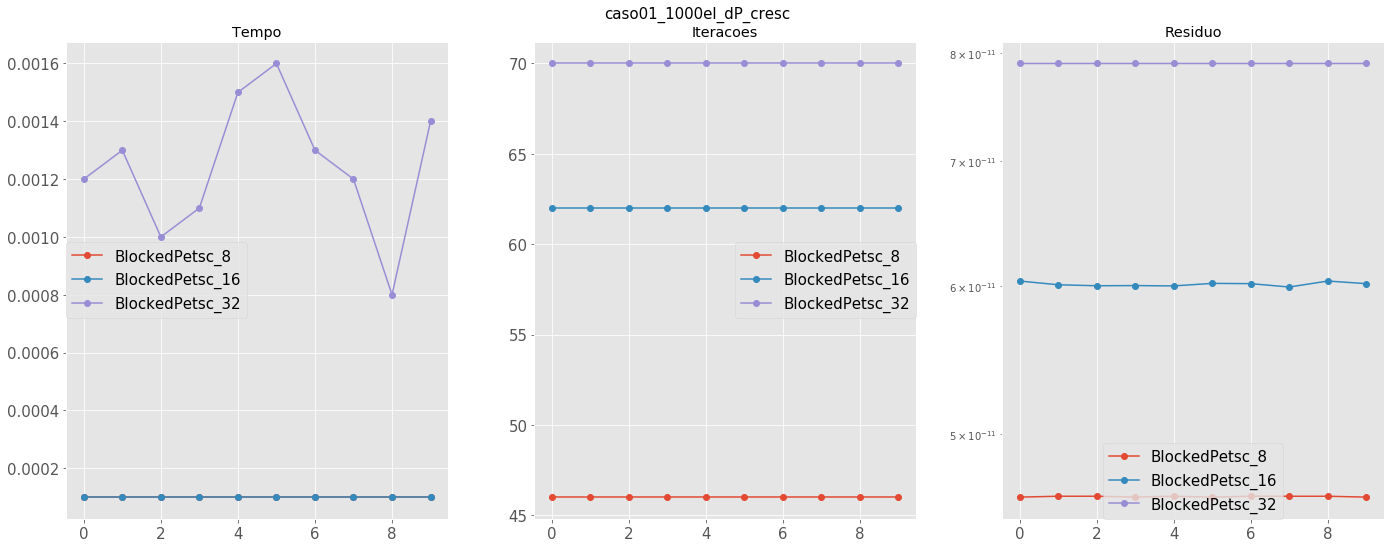

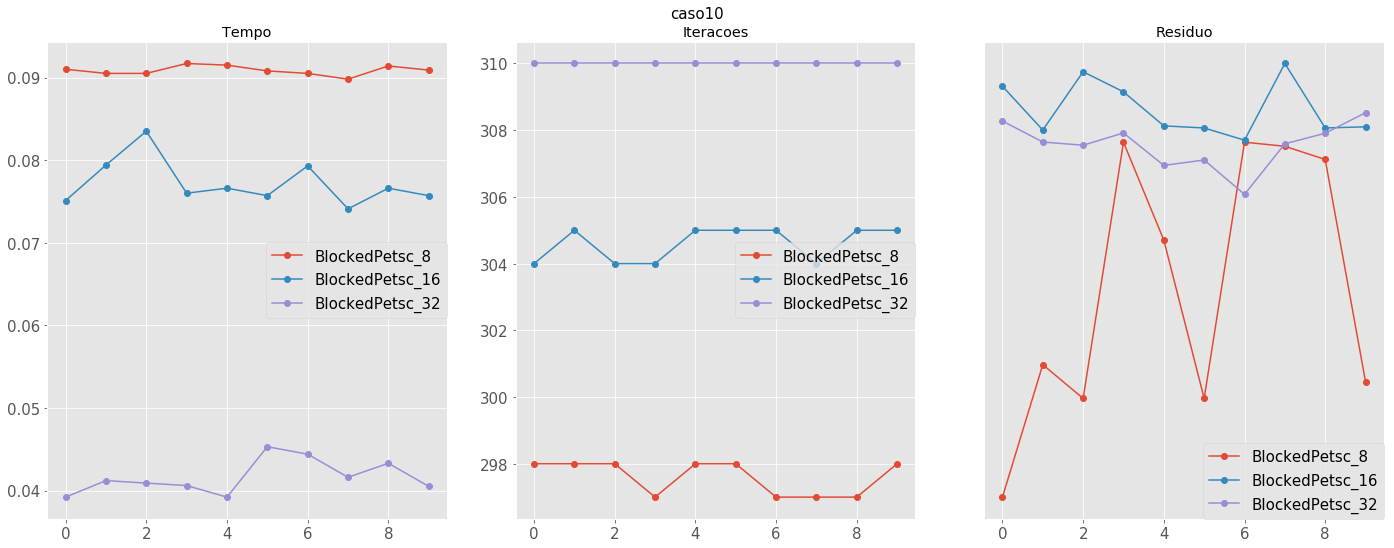

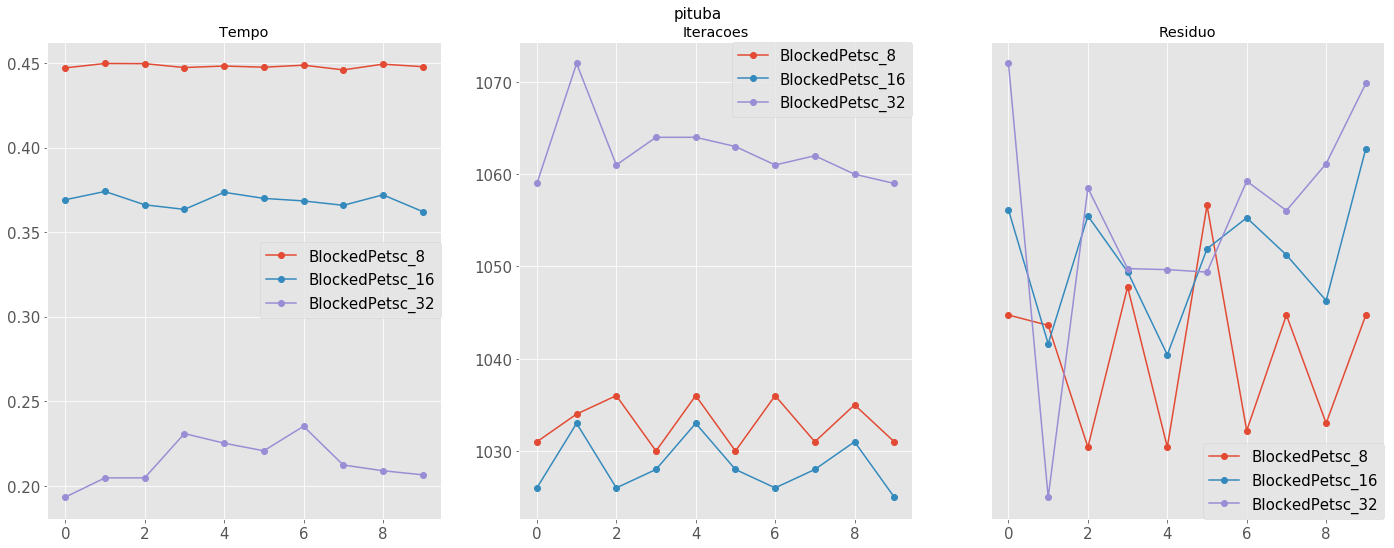

In [148]:
results = pd.DataFrame(columns=columns)

files = glob.glob("./LogSolver/rodada_cluster_2nos_tol*.txt")

for filename in files:
    results = results.append(read_results(filename), ignore_index=True)    
results["Nos"] = 2
plot_tempo_iters_residuo(results, procs = [8, 16, 32], tipos = ["BlockedPetsc"])

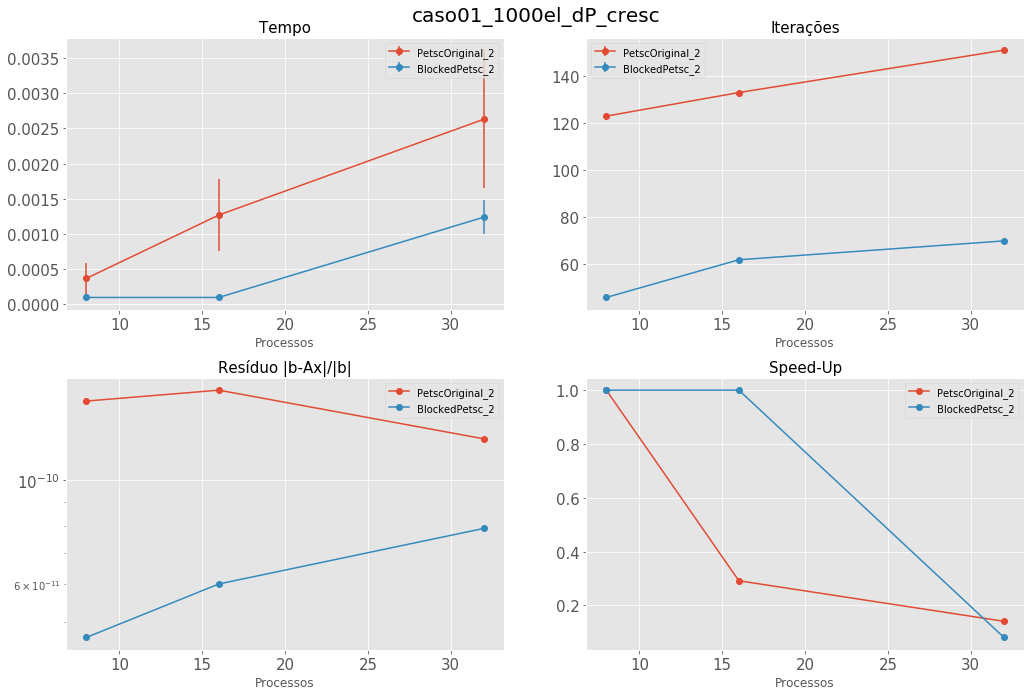

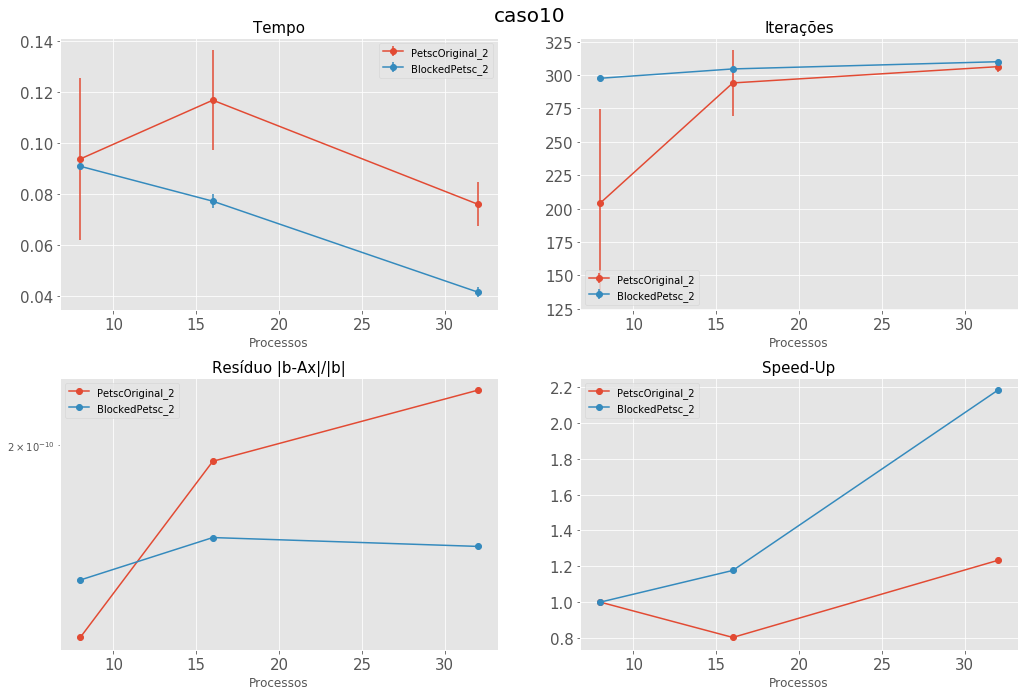

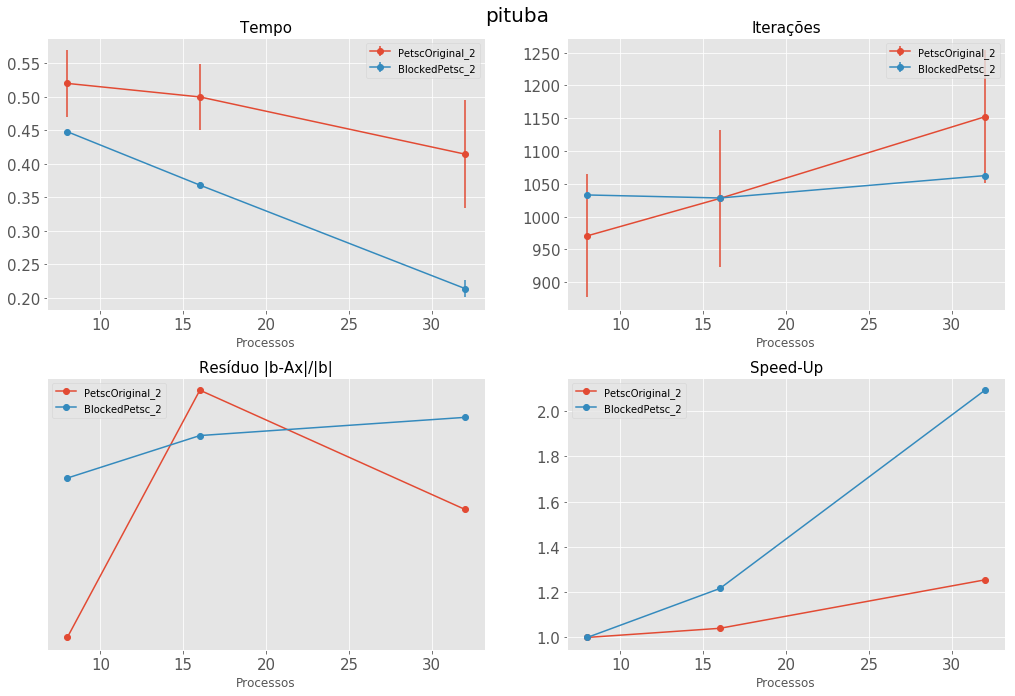

In [149]:
results["Iteracoes"] = results["Iteracoes"].astype(int)

mean_data = get_mean_data(results, ["Caso", "Tipo", "Processos"], ["TempoSolver", "Residuo", "Iteracoes"])

plot_mean_data(mean_data, tipos=["PetscOriginal", "BlockedPetsc"])

